In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.ensemble import BalancedBaggingClassifier, RUSBoostClassifier
from imblearn.metrics import classification_report_imbalanced
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, f1_score, accuracy_score, auc, roc_auc_score, precision_recall_curve, precision_score, recall_score, average_precision_score, make_scorer, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from smote import SMOTEBoost

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

random_state = 11

Importing Data and Feature Scaling/Transformaiton

In [2]:
data = pd.read_csv('../data/model_nyc_crash.csv')
data['crash_datetime'] = pd.to_datetime(data['crash_datetime'])
drop_cols = ['collision_id', 'crash_datetime', 'latitude', 'longitude', 'geometry', 'unique_id', 'zip_code','rain_1mm',
             'borough', 'injury_type', 'injury_severity', 'total_commute_population', 'commute_car', 'commute_public_transport',
             'commute_walk', 'commute_other', 'total_population_poverty', 'below_poverty_count', 'cam_type']
data = data.drop(columns=drop_cols)
data.describe()

person_age  cam_distance      avg_temp  street_width  median_income  \
count  74272.000000  74272.000000  74272.000000  74272.000000   74272.000000   
mean      38.230127    465.161388     14.552403     12.770574   77330.002774   
std       18.735838    348.261799      9.087788      3.998478   35501.209010   
min        1.000000      0.000000    -12.800000      0.000000   21846.000000   
25%       24.000000    228.135069      6.800000      9.114000   52273.000000   
50%       35.000000    386.051300     15.100000     12.152000   68542.000000   
75%       52.000000    627.830250     22.800000     15.190000   95478.000000   
max      102.000000   3692.445066     33.400000     31.595200  250001.000000   

       commute_car_percent  commute_public_transport_percent  \
count         74272.000000                      74272.000000   
mean             10.404798                         26.158680   
std               7.047486                          6.679849   
min               0.950920                          2.267675   
25%               5.329720                         22.031118   
50%               7.842901                         25.822213   
75%              14.243614                         30.191314   
max              36.028225                         52.897013   

       commute_walk_percent  commute_other_percent  \
count          74272.000000           74272.000000   
mean               0.776849               5.899513   
std                0.777510               5.972996   
min                0.000000               0.000000   
25%                0.187679               2.641104   
50%                0.484684               3.520114   
75%                1.034445               6.410692   
max                3.484496              28.830889   

       below_poverty_count_percent  complaints_within100m  
count                 74272.000000           74272.000000  
mean                     17.802205             291.254537  
std                       9.194000             247.607901  
min                       1.305696               0.000000  
25%                      10.406411             153.000000  
50%                      15.165978             237.000000  
75%                      24.185872             357.000000  
max                      44.020179            9072.000000

In [3]:
scaler = StandardScaler()
label_encoder = LabelEncoder()
numerical_columns = ['person_age', 'cam_distance', 'avg_temp', 'street_width', 'median_income', 'commute_car_percent', 
                     'commute_public_transport_percent', 'commute_walk_percent', 'commute_other_percent', 'below_poverty_count_percent', 'complaints_within100m']

categorical_columns = ['vehicle_type_1', 'contributing_factor_vehicle_1']

binary_columns = ['person_type', 'crash_severity', 'person_sex', 'is_weekend', 'is_night', 'near_cam', 'snow', 'rain_2.5mm',
                  'within_vz_priority', 'near_calming']

data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

data = pd.get_dummies(data, columns=categorical_columns, prefix=categorical_columns,  dtype=int)
for col in binary_columns:
  data[col] = label_encoder.fit_transform(data[col])
data.head()

person_type  crash_severity  person_age  person_sex  is_weekend  is_night  \
0            0               0   -0.119031           0           0         1   
1            1               0   -0.652771           0           0         0   
2            1               0    1.535563           0           0         0   
3            0               0   -0.919641           1           0         0   
4            0               0   -0.812893           1           0         0   

   near_cam  cam_distance  avg_temp  snow  ...  vehicle_type_1_SUV/Pickup  \
0         0      0.553987  0.874542     0  ...                          0   
1         0     -0.520866  1.138634     0  ...                          0   
2         0     -0.317658  0.874542     0  ...                          0   
3         0     -0.529555  0.874542     0  ...                          0   
4         0      1.497979  1.138634     0  ...                          1   

   vehicle_type_1_Sedan  vehicle_type_1_Taxi  \
0                     0                    1   
1                     1                    0   
2                     1                    0   
3                     0                    0   
4                     0                    0   

   contributing_factor_vehicle_1_Driver Inattention/Distraction  \
0                                                  0              
1                                                  0              
2                                                  1              
3                                                  1              
4                                                  0              

   contributing_factor_vehicle_1_Drugs/Alcohol  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

   contributing_factor_vehicle_1_Environmental  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

   contributing_factor_vehicle_1_Pedestrian/Bicyclist Error  \
0                                                  1          
1                                                  0          
2                                                  0          
3                                                  0          
4                                                  0          

   contributing_factor_vehicle_1_Speeding/Traffic Violation  \
0                                                  0          
1                                                  1          
2                                                  0          
3                                                  0          
4                                                  1          

   contributing_factor_vehicle_1_Unsafe Driving  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   contributing_factor_vehicle_1_Vehicle Defective  
0                                                0  
1                                                0  
2                                                0  
3                                                0  
4                                                0  

[5 rows x 35 columns]

Feature Analysis

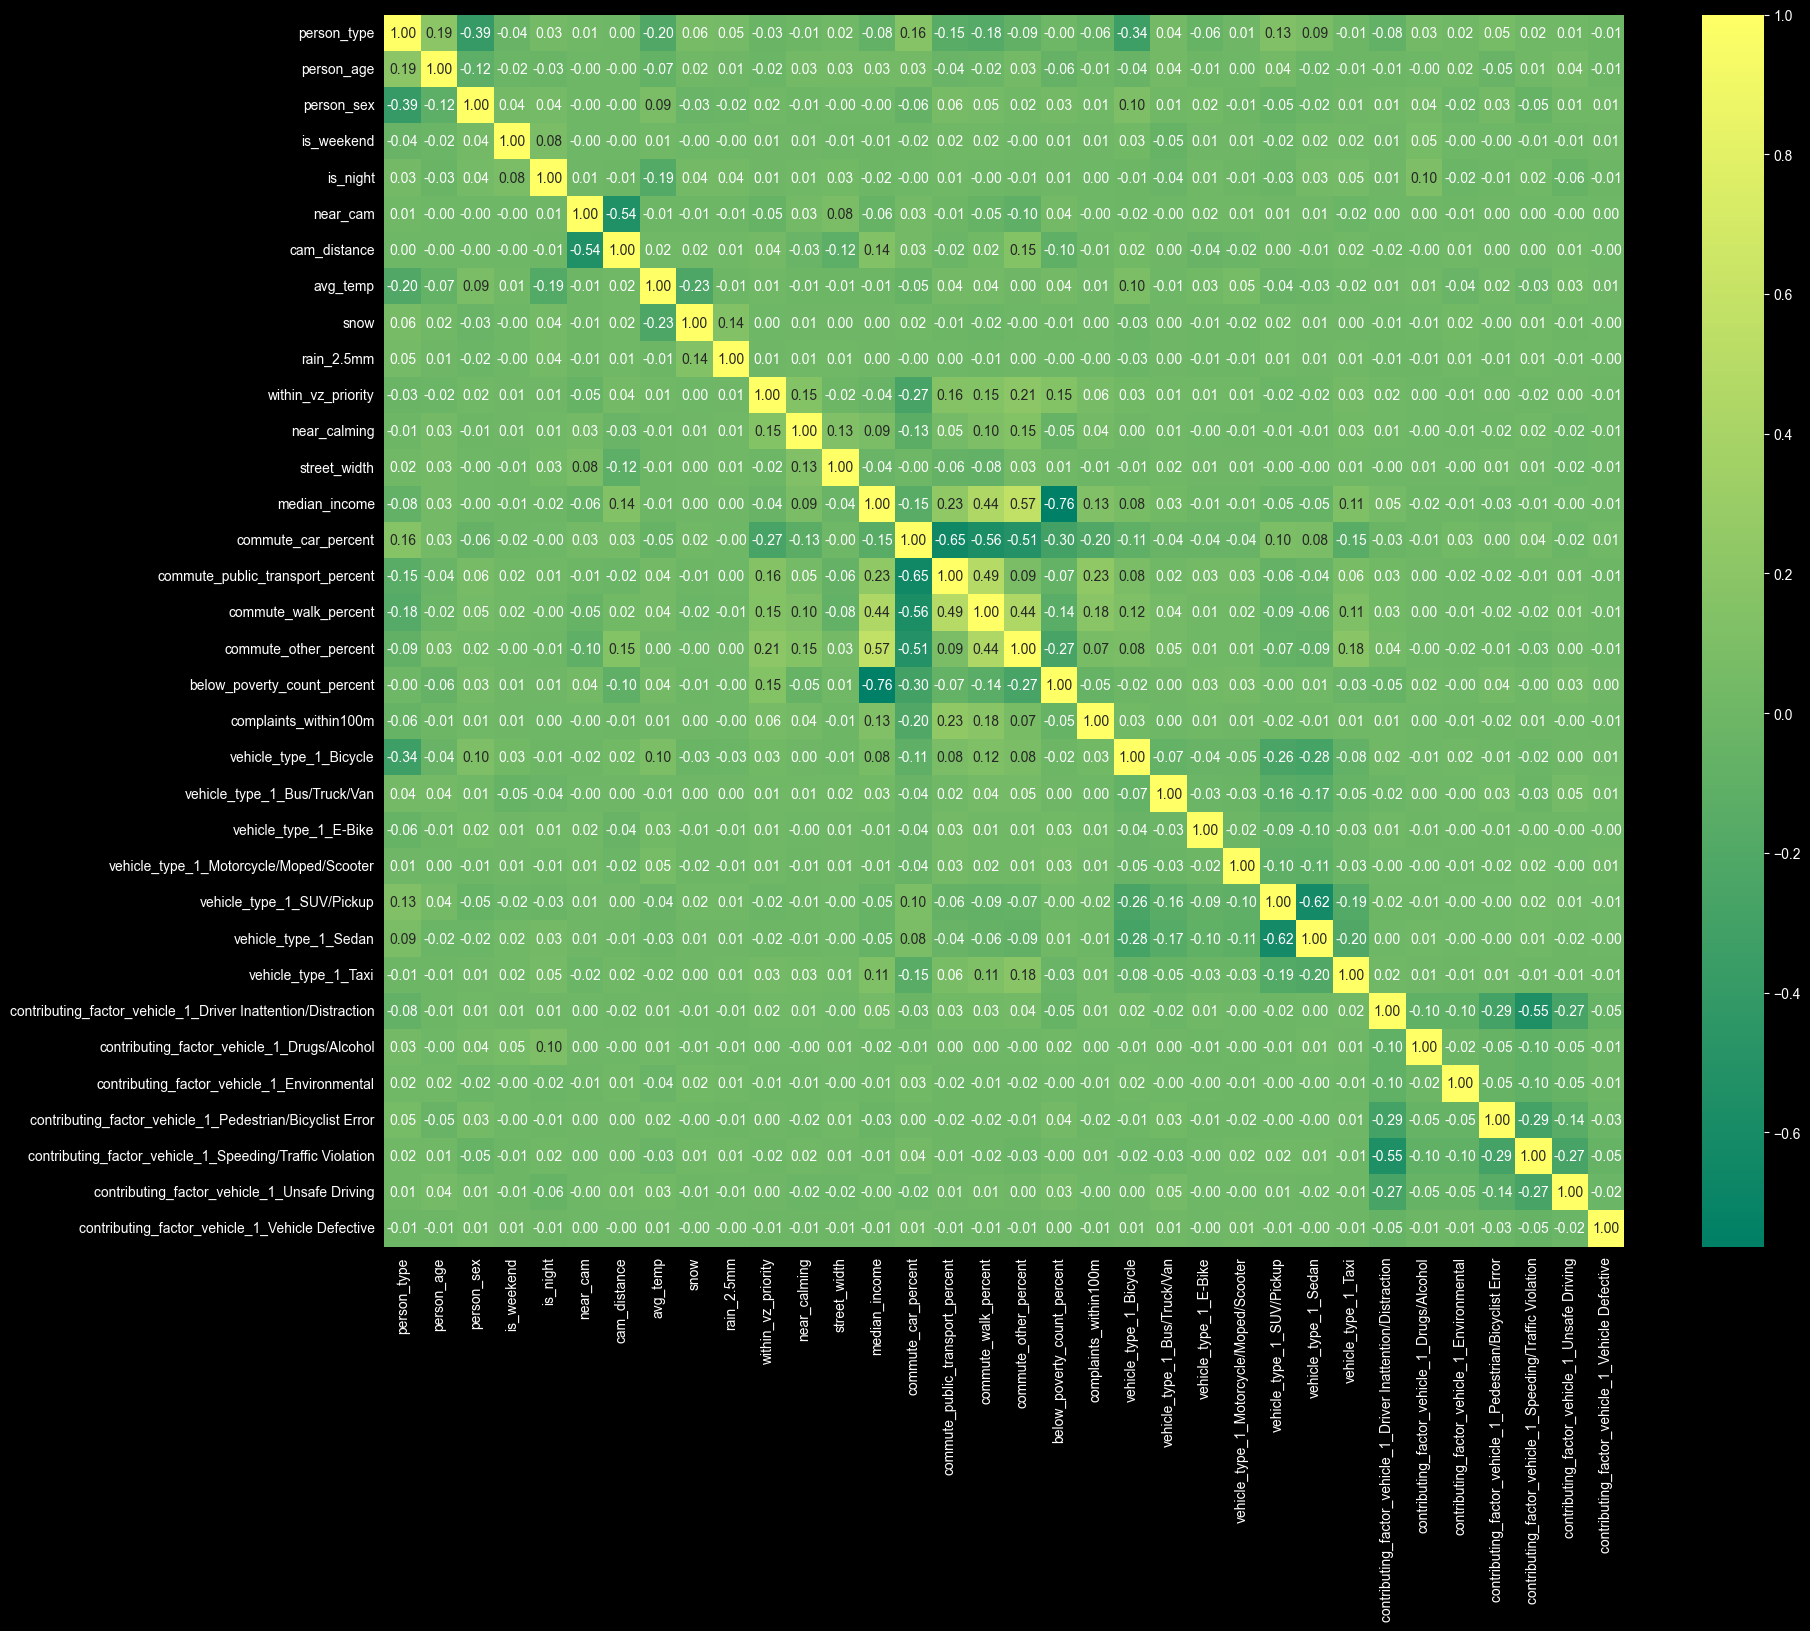

In [74]:
X = data.drop('crash_severity', axis=1)
y = data['crash_severity']
corr_matrix = X.corr()
plt.figure(figsize=(20, 16))
plt.style.use('dark_background')
sns.heatmap(corr_matrix, annot=True, cmap="summer", fmt=".2f")
plt.show()

In [6]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)
explained_variance_ratio = pca.explained_variance_ratio_

variance_df = pd.DataFrame({
    'Feature': X.columns,
    'Explained_Variance_Ratio': explained_variance_ratio
})

pd.set_option('display.float_format', lambda x: '%.11f' % x)

print(variance_df.head(10).to_string(index=False))


     Feature  Explained_Variance_Ratio
 person_type             0.99985738775
  person_age             0.00009441386
  person_sex             0.00004772371
  is_weekend             0.00000027882
    is_night             0.00000007117
    near_cam             0.00000006311
cam_distance             0.00000002891
    avg_temp             0.00000001576
        snow             0.00000001208
  rain_2.5mm             0.00000000227


In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data_frame):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data_frame.columns
    vif_data["VIF"] = [variance_inflation_factor(data_frame.values, i) for i in range(data_frame.shape[1])]
    return vif_data
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    vif_results = calculate_vif(X).reset_index()
vif_results.sort_values(by='VIF', ascending=False)

index                                           Variable       VIF
33     33    contributing_factor_vehicle_1_Vehicle Defective       inf
27     27  contributing_factor_vehicle_1_Driver Inattenti...       inf
21     21                       vehicle_type_1_Bus/Truck/Van       inf
22     22                              vehicle_type_1_E-Bike       inf
23     23            vehicle_type_1_Motorcycle/Moped/Scooter       inf
24     24                          vehicle_type_1_SUV/Pickup       inf
26     26                                vehicle_type_1_Taxi       inf
25     25                               vehicle_type_1_Sedan       inf
28     28        contributing_factor_vehicle_1_Drugs/Alcohol       inf
29     29        contributing_factor_vehicle_1_Environmental       inf
30     30  contributing_factor_vehicle_1_Pedestrian/Bicyc...       inf
31     31  contributing_factor_vehicle_1_Speeding/Traffic...       inf
32     32       contributing_factor_vehicle_1_Unsafe Driving       inf
20     20                             vehicle_type_1_Bicycle       inf
14     14                                commute_car_percent  8.712726
18     18                        below_poverty_count_percent  6.074179
13     13                                      median_income  4.563738
15     15                   commute_public_transport_percent  4.315523
17     17                              commute_other_percent  4.301812
16     16                               commute_walk_percent  1.887037
6       6                                       cam_distance  1.498397
0       0                                        person_type  1.458413
5       5                                           near_cam  1.423778
2       2                                         person_sex  1.204279
10     10                                 within_vz_priority  1.179026
7       7                                           avg_temp  1.148344
8       8                                               snow  1.078784
19     19                              complaints_within100m  1.077754
11     11                                       near_calming  1.077077
4       4                                           is_night  1.070670
1       1                                         person_age  1.059512
12     12                                       street_width  1.054376
9       9                                         rain_2.5mm  1.025916
3       3                                         is_weekend  1.015657

In [22]:
from libpysal.weights import KNN
import libpysal
from esda.moran import Moran
import geopandas as gpd
from shapely import wkt

radius = libpysal.cg.RADIUS_EARTH_KM

moran_df = pd.read_csv('../data/model_nyc_crash.csv')
moran_df['crash_datetime'] = pd.to_datetime(moran_df['crash_datetime'])
drop_cols = ['collision_id', 'crash_datetime', 'unique_id', 'zip_code','rain_1mm','borough', 'injury_type',
            'injury_severity', 'total_commute_population', 'commute_car', 'commute_public_transport',
            'commute_walk', 'commute_other', 'total_population_poverty', 'below_poverty_count', 'cam_type']
moran_df = moran_df.drop(columns=drop_cols)
moran_killed = moran_df[moran_df['crash_severity'] == 'Killed']
moran_killed = moran_killed.copy()

moran_df['geometry'] = moran_df['geometry'].apply(wkt.loads)
moran_killed['geometry'] = moran_killed['geometry'].apply(wkt.loads)

gdf_moran_killed = gpd.GeoDataFrame(moran_killed, geometry='geometry')
gdf_moran_total = gpd.GeoDataFrame(moran_df, geometry='geometry')

gdf_list = {"Killed" : gdf_moran_killed, "All Crashes": gdf_moran_total}
print("Spatial autocorrelation analysis of crashes with at least one injury or death and 311 road safety complaints:")
for name, gdf in gdf_list.items():
    w= KNN.from_dataframe(gdf, geom_col='geometry', k=4, radius=radius) 
    w.transform = 'R'

    moran = Moran(gdf['complaints_within100m'], w)

    print(f"Moran's I for {name}:", moran.I)
    print(f"p-value for {name}:", moran.p_sim)


Spatial autocorrelation analysis of crashes with at least one injury or death and 311 road safety complaints:
Moran's I for Killed: 0.288357457370679
p-value for Killed: 0.001
Moran's I for All Crashes: 0.8778764664399428
p-value for All Crashes: 0.001


Model Selection

In [4]:
X = data.drop('crash_severity', axis=1)
y = data['crash_severity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)

In [14]:
def pr_auc(y_true, y_pred_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    return auc(recall, precision)

classifiers = {
    "DummyClassifier_most_frequent": DummyClassifier(strategy='most_frequent', random_state=random_state),
    "LogisticRegression": LogisticRegression(solver = 'lbfgs', max_iter=10000),
    "LinearDiscriminantAnalysis": LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto'),
    "XGBClassifier": XGBClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "CatBoost" : CatBoostClassifier(iterations=100, depth=5, learning_rate=0.1, verbose=False),
    "GaussianNB" : GaussianNB(),
    "GradientBoostingClassifier" : GradientBoostingClassifier(),
    "BalancedBagging": BalancedBaggingClassifier(),
    "RUSBoostClassifier": RUSBoostClassifier()
    }

scoring_functions = {
                    'accuracy': make_scorer(accuracy_score),
                    'precision': make_scorer(precision_score, zero_division=1),
                    'recall': make_scorer(recall_score, zero_division=1),
                    'roc_auc': make_scorer(roc_auc_score),
                    'f1_score': make_scorer(f1_score),
                    'avg_precision': make_scorer(average_precision_score),
                    'pr_auc' : make_scorer(pr_auc, needs_threshold=True),
                    'f2_score' : make_scorer(fbeta_score, beta=2)
                    }

results = []
for key, classifier in classifiers.items():
    sampler = {"over_first": [('over', SMOTE(random_state=random_state, sampling_strategy=.1)), ('under', RandomUnderSampler(random_state=random_state ,sampling_strategy=.5)), ('model', classifier)],
           "under_first": [('under', RandomUnderSampler(random_state=random_state, sampling_strategy=.1)), ('over', SMOTE(random_state=random_state, sampling_strategy=.5)), ('model', classifier)]}

    for pipe_type, pipeline in sampler.items():


        print('*', f"{key}_{pipe_type}")
        start_time = time.time()
        
        row = {'model': f"{key}_{pipe_type}"}
        pipeline = Pipeline(pipeline)

        for metric, scoring_function in scoring_functions.items():
            cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=random_state)
            cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=scoring_function)
            row[f'avg_{metric}'] = cv_scores.mean()
            #row[f'avg_{metric}_std'] = cv_scores.std()
            
        row['run_time'] = round((time.time() - start_time) / 60, 2)
        results.append(row)

df_models = pd.DataFrame(results)
df_sorted = df_models.sort_values('avg_avg_precision', ascending=False).reset_index()
styled_df = df_sorted.style.highlight_max(axis=0, color='#fa8c00', subset=df_sorted.columns.difference(['model', 'index']))
styled_df

* DummyClassifier_most_frequent_over_first
* DummyClassifier_most_frequent_under_first
* LogisticRegression_over_first
* LogisticRegression_under_first
* LinearDiscriminantAnalysis_over_first
* LinearDiscriminantAnalysis_under_first
* XGBClassifier_over_first
* XGBClassifier_under_first
* DecisionTreeClassifier_over_first
* DecisionTreeClassifier_under_first
* RandomForestClassifier_over_first
* RandomForestClassifier_under_first
* CatBoost_over_first
* CatBoost_under_first
* GaussianNB_over_first
* GaussianNB_under_first
* GradientBoostingClassifier_over_first
* GradientBoostingClassifier_under_first
* BalancedBagging_over_first
* BalancedBagging_under_first
* RUSBoostClassifier_over_first
* RUSBoostClassifier_under_first


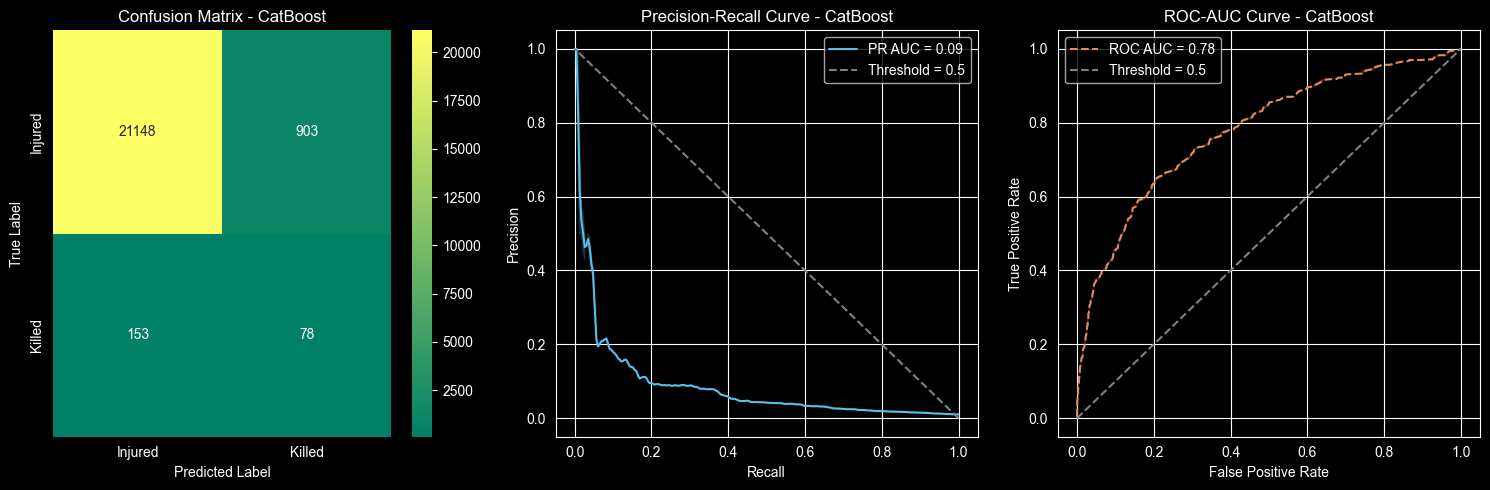

RESULTS FOR CatBoost
Average Precision: 0.08808658640084543
Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.96      0.34      0.98      0.57      0.34     22051
          1       0.08      0.34      0.96      0.13      0.57      0.30       231

avg / total       0.98      0.95      0.34      0.97      0.57      0.34     22282

AUC: 0.7793415146823155
AUPRC: 0.0865779630605621


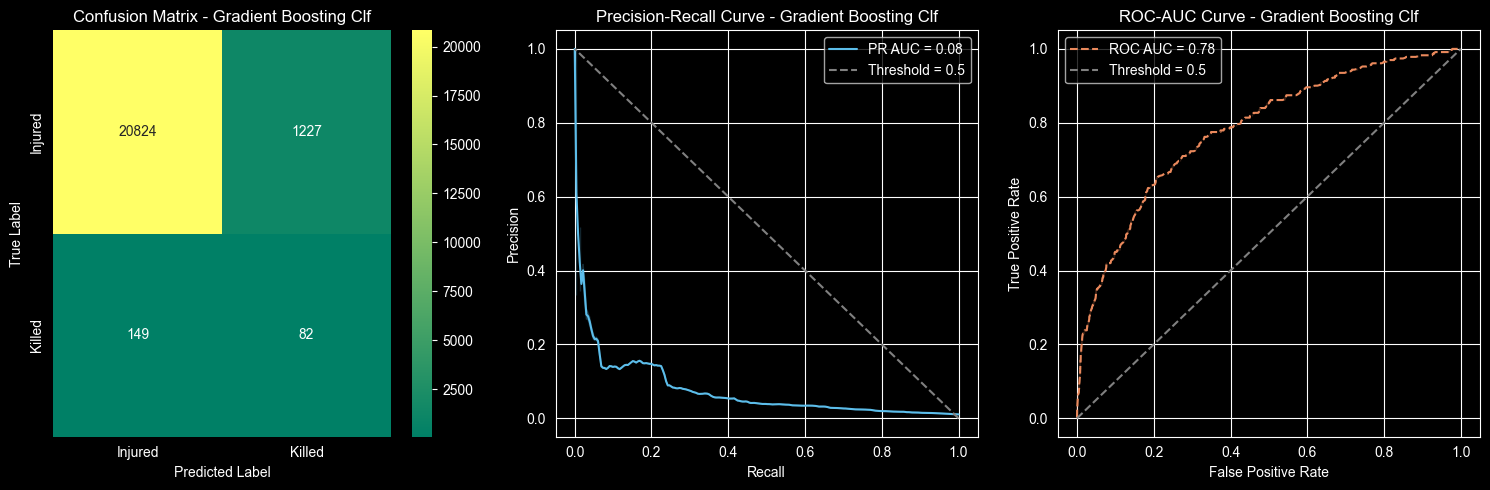

RESULTS FOR Gradient Boosting Clf
Average Precision: 0.0771476018202587
Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.94      0.35      0.97      0.58      0.35     22051
          1       0.06      0.35      0.94      0.11      0.58      0.32       231

avg / total       0.98      0.94      0.36      0.96      0.58      0.35     22282

AUC: 0.7823875820338566
AUPRC: 0.07538595810630634


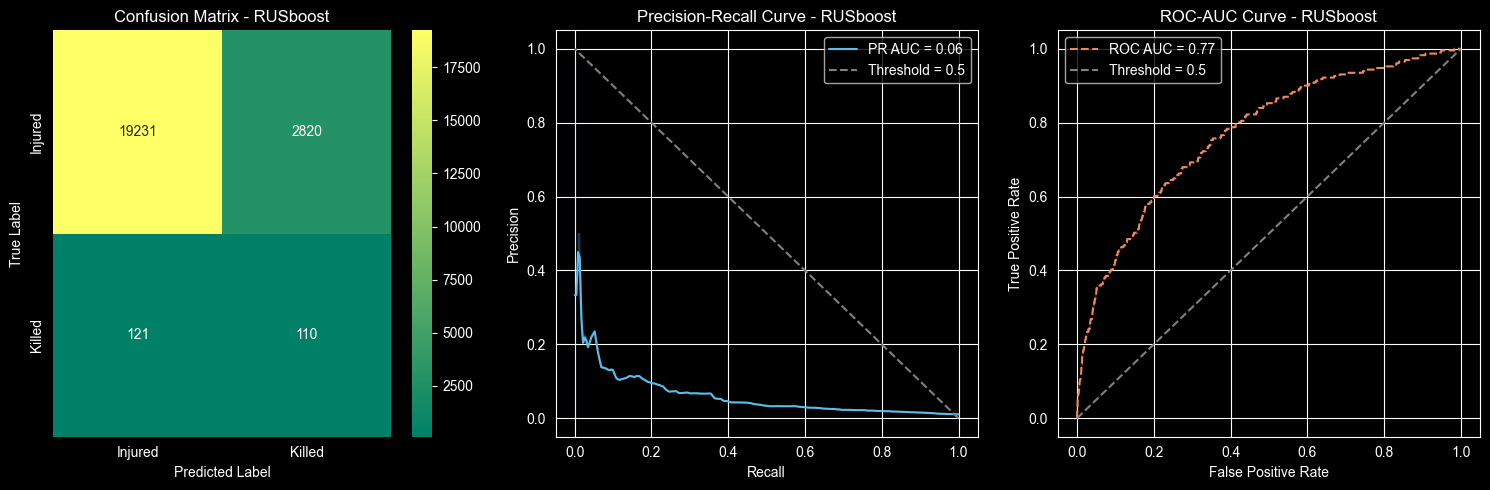

RESULTS FOR RUSboost
Average Precision: 0.06285224475073467
Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.87      0.48      0.93      0.64      0.43     22051
          1       0.04      0.48      0.87      0.07      0.64      0.40       231

avg / total       0.98      0.87      0.48      0.92      0.64      0.43     22282

AUC: 0.7705383289937278
AUPRC: 0.060566589750357364


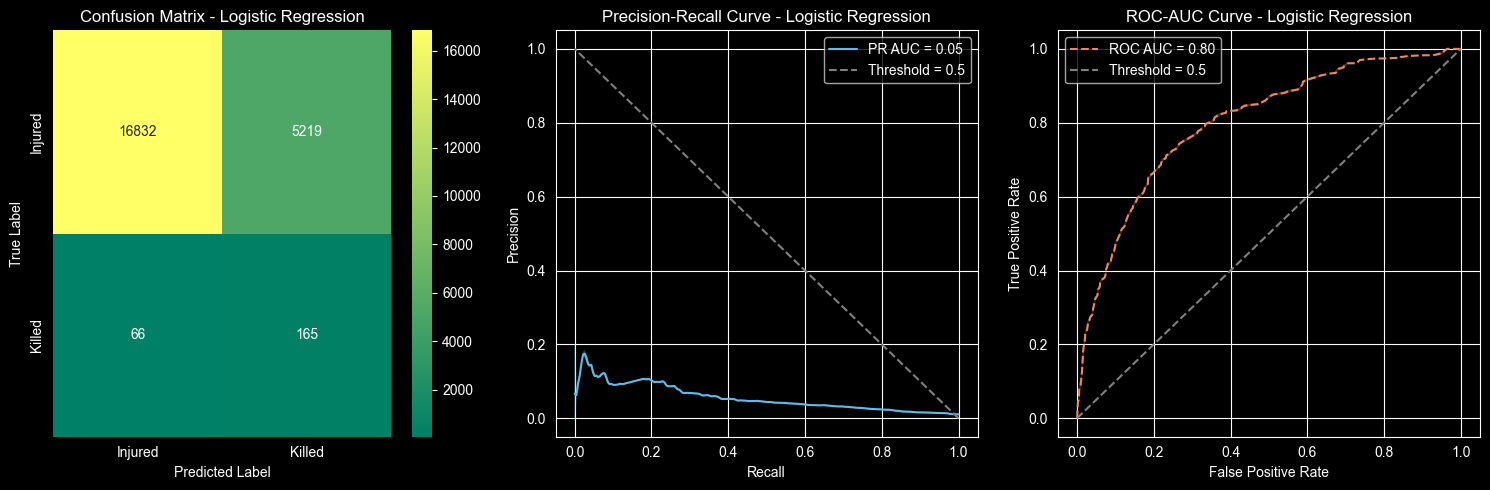

RESULTS FOR Logistic Regression
Average Precision: 0.05605527163884723
Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.76      0.71      0.86      0.74      0.55     22051
          1       0.03      0.71      0.76      0.06      0.74      0.54       231

avg / total       0.99      0.76      0.71      0.86      0.74      0.55     22282

AUC: 0.8006845013556727
AUPRC: 0.05489766384647777


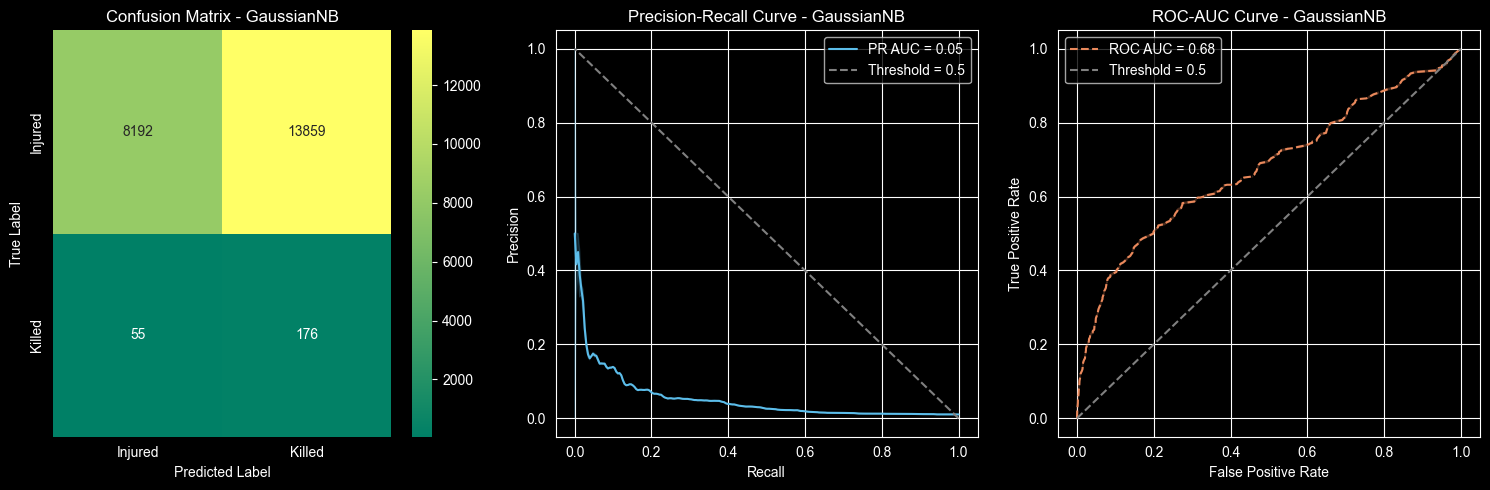

RESULTS FOR GaussianNB
Average Precision: 0.0537718752971399
Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.37      0.76      0.54      0.53      0.27     22051
          1       0.01      0.76      0.37      0.02      0.53      0.29       231

avg / total       0.98      0.38      0.76      0.54      0.53      0.27     22282

AUC: 0.6780283643917946
AUPRC: 0.051138324769244334


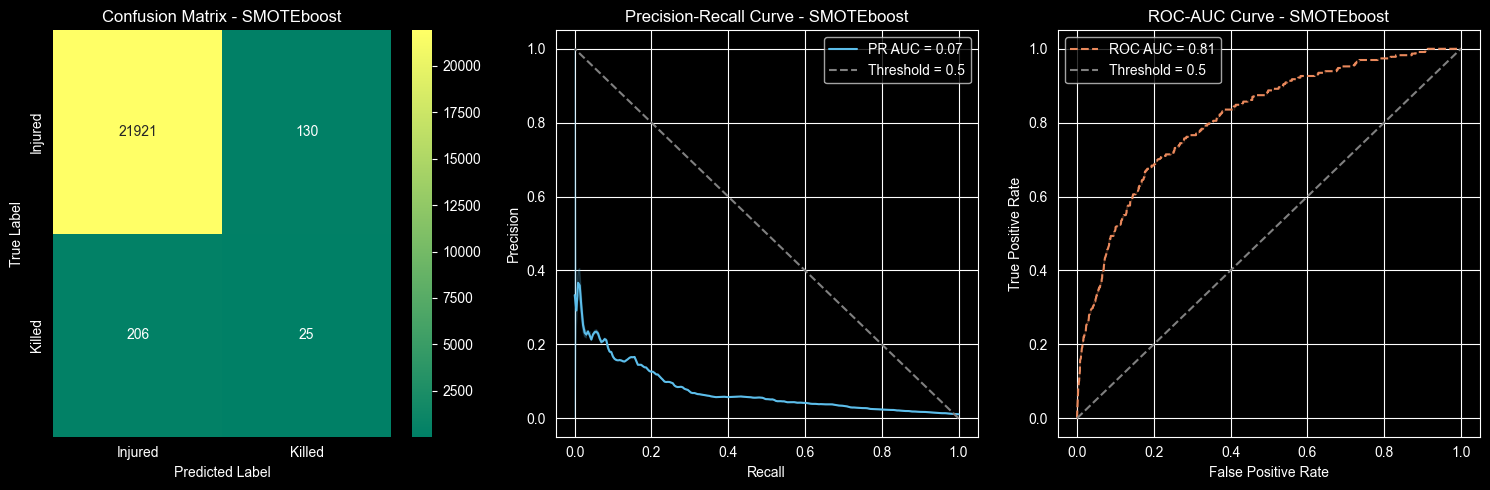

RESULTS FOR SMOTEboost
Average Precision: 0.07684772472867527
Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      0.11      0.99      0.33      0.12     22051
          1       0.16      0.11      0.99      0.13      0.33      0.10       231

avg / total       0.98      0.98      0.12      0.98      0.33      0.12     22282

AUC: 0.8116866429868108
AUPRC: 0.07441086438944224


In [75]:
classifier_steps = {"CatBoost": 
                        [('under', RandomUnderSampler(sampling_strategy=0.1, random_state=random_state)), 
                         ('over', SMOTE(random_state=random_state, sampling_strategy=0.5)), 
                         ('model', CatBoostClassifier(iterations=100, depth=5, learning_rate=0.1, verbose=False))],
                    "Gradient Boosting Clf":
                        [('under', RandomUnderSampler(sampling_strategy=0.1, random_state=random_state)), 
                         ('over', SMOTE(random_state=random_state, sampling_strategy=0.5)), 
                         ('model', GradientBoostingClassifier())],
                    "RUSboost": 
                        [('under', RandomUnderSampler(sampling_strategy=0.1, random_state=random_state)), 
                         ('over', SMOTE(random_state=random_state, sampling_strategy=0.5)), 
                         ('model', RUSBoostClassifier())],
                    "Logistic Regression": 
                        [('under', RandomUnderSampler(random_state=random_state)), 
                         ('model', LogisticRegression())],
                    "GaussianNB":
                        [('over', SMOTE(sampling_strategy=0.1, random_state=random_state)), 
                         ('under', RandomUnderSampler(random_state=random_state, sampling_strategy=0.5)), 
                         ('model', GaussianNB())],
                    "SMOTEboost":
                        [('under', RandomUnderSampler(random_state=random_state, sampling_strategy=0.025)),
                         ('model', SMOTEBoost(n_estimators=500, learning_rate=.5))]
}

for name, steps in classifier_steps.items():
    pipeline = Pipeline(steps=steps)

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_scores = pipeline.predict_proba(X_test)[:, 1]

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(15, 5))
    plt.style.use('dark_background')

    #Confusion Matrix
    plt.subplot(1, 3, 1)
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="summer", xticklabels=["Injured", "Killed"], yticklabels=["Injured", "Killed"]
    )
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    #Precision Recall Curve
    plt.subplot(1, 3, 2)
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(recall, precision)
    sns.lineplot(x=recall, y=precision, label=f"PR AUC = {pr_auc:.2f}", color='#5cbdea', linestyle='-')
    plt.plot([1, 0], [0, 1], color='gray', linestyle='--', label='Threshold = 0.5')

    plt.title(f"Precision-Recall Curve - {name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid(True)

    #ROC-AUC Curve
    plt.subplot(1, 3, 3)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    sns.lineplot(x=fpr, y=tpr, label=f"ROC AUC = {roc_auc:.2f}", color='#ea895c', linestyle='--')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Threshold = 0.5')

    plt.title(f"ROC-AUC Curve - {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"RESULTS FOR {name}")
    avg_prec = average_precision_score(y_test, y_scores)
    confusion = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    imbalanced_report = classification_report_imbalanced(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_scores)
    auprc = auc(recall, precision)

    print(f"Average Precision: {avg_prec}")
    print(f"Imbalanced Classification Report:\n{imbalanced_report}")
    print("AUC:", roc_auc)
    print(f"AUPRC: {auprc}")

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

classifier_steps = {
    "CatBoost": 
        [('under', RandomUnderSampler(sampling_strategy=0.1, random_state=random_state)),
         ('over', SMOTE(random_state=random_state, sampling_strategy=0.5)),
         ('model', CatBoostClassifier(verbose=False))],
    "Gradient Boosting Clf": 
        [('under', RandomUnderSampler(sampling_strategy=0.1, random_state=random_state)),
         ('over', SMOTE(random_state=random_state, sampling_strategy=0.5)),
         ('model', GradientBoostingClassifier())],
    "RUSboost": 
        [('under', RandomUnderSampler(sampling_strategy=0.1, random_state=random_state)), 
         ('over', SMOTE(random_state=random_state, sampling_strategy=0.5)), 
         ('model', RUSBoostClassifier())]
}

param_dists = {
    "CatBoost": {
        'model__iterations': randint(100, 1000),
        'model__depth': randint(4, 10),
        'model__learning_rate': uniform(0.001, 0.2),
        'model__bootstrap_type': ['Bernoulli', 'MVS']
    },
    "Gradient Boosting Clf": {
        'model__n_estimators': randint(50, 300),
        'model__learning_rate': uniform(0.001, 0.2),
        'model__max_depth': randint(3, 8),
        'model__min_samples_split': randint(2, 20),
        'model__min_samples_leaf': randint(1, 8),
        'model__subsample': [0.8, 0.9, 1.0],
        'model__max_features': ['sqrt', 'log2', None]
    },
    "RUSboost": {
        'model__n_estimators': randint(50, 500),
        'model__learning_rate': uniform(0.01, 0.2),
        'model__algorithm': ['SAMME', 'SAMME.R'],
        'model__replacement': [True, False]
    },
    "Logistic Regression": {
        'model__C': uniform(0.001, 10),
        'model__penalty': ['l1', 'l2'],
        'model__class_weight': [None, 'balanced'],
        'model__solver': ['liblinear', 'lbfgs'],
        'model__max_iter': randint(10000, 20000)
    }
}

for name, steps in classifier_steps.items():
    pipeline = Pipeline(steps=steps)
    random_search = RandomizedSearchCV(
        pipeline,
        param_dists[name],
        n_iter=100,  # Increase for wider search
        cv=5,
        scoring='recall',
        n_jobs=-1,
        random_state=random_state,
        verbose=1
    )
    
    random_search.fit(X_train, y_train)

    print(f"Best parameters for {name}:", random_search.best_params_)
    print(f"Best Recall score for {name}:", random_search.best_score_)

    best_model = random_search.best_estimator_

    y_scores = best_model.predict_proba(X_test)[:, 1]
    avg_prec = average_precision_score(y_test, y_scores)
    print(f"Average Precision for best {name} model on test set:", avg_prec)
    print()


Fitting 5 folds for each of 100 candidates, totalling 500 fits


Best parameters for CatBoost: {'model__bootstrap_type': 'Bernoulli', 'model__depth': 4, 'model__iterations': 780, 'model__learning_rate': 0.009980964722747319}
Best Recall score for CatBoost: 0.40370370370370373
Average Precision for best CatBoost model on test set: 0.07828794026991644

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters for Gradient Boosting Clf: {'model__learning_rate': 0.05163655380155823, 'model__max_depth': 3, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 4, 'model__min_samples_split': 18, 'model__n_estimators': 200, 'model__subsample': 1.0}
Best Recall score for Gradient Boosting Clf: 0.4296296296296297
Average Precision for best Gradient Boosting Clf model on test set: 0.07126106907248927

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters for RUSboost: {'model__algorithm': 'SAMME.R', 'model__learning_rate': 0.021016966421157194, 'model__n_estimators': 213, 'model__replacement': False}
Best Recal

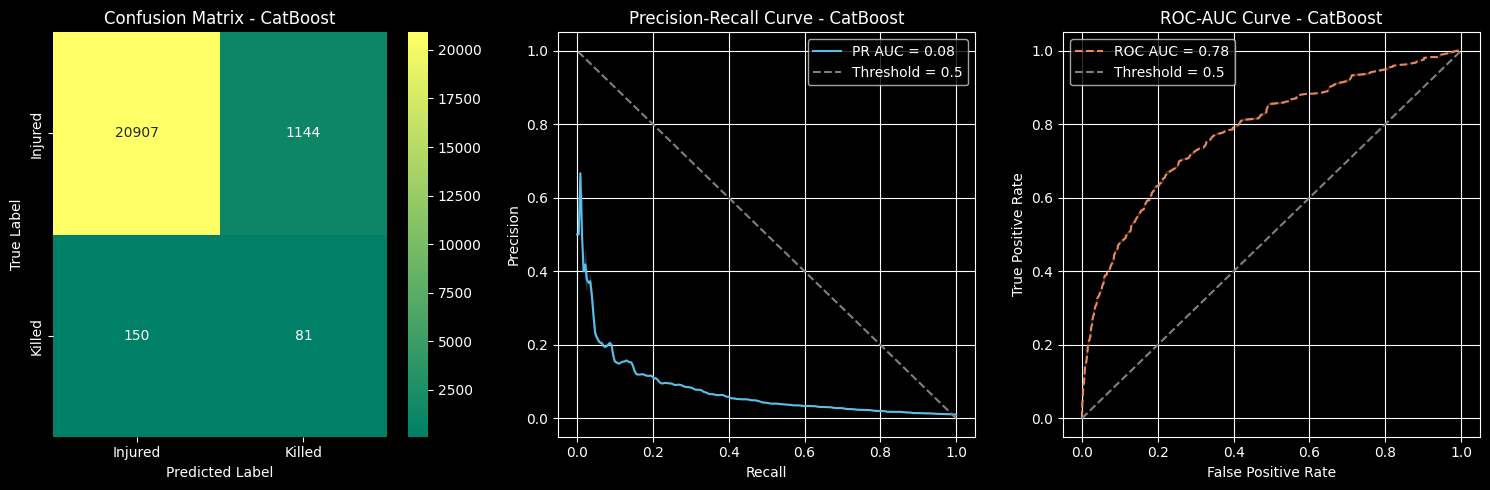

RESULTS FOR CatBoost
Average Precision: 0.07933862835520852
Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.95      0.35      0.97      0.58      0.35     22051
          1       0.07      0.35      0.95      0.11      0.58      0.31       231

avg / total       0.98      0.94      0.36      0.96      0.58      0.35     22282

AUC: 0.7797155001363427
AUPRC: 0.07645408485602342


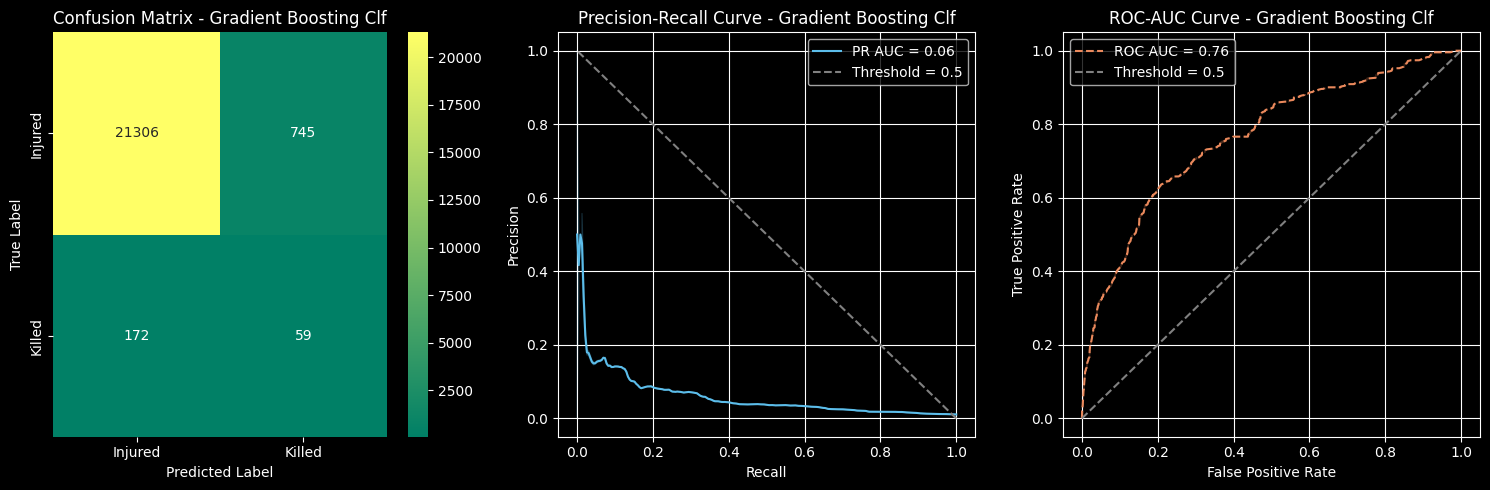

RESULTS FOR Gradient Boosting Clf
Average Precision: 0.061924937612725606
Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.97      0.26      0.98      0.50      0.26     22051
          1       0.07      0.26      0.97      0.11      0.50      0.23       231

avg / total       0.98      0.96      0.26      0.97      0.50      0.26     22282

AUC: 0.7647633457347303
AUPRC: 0.05929368424829435


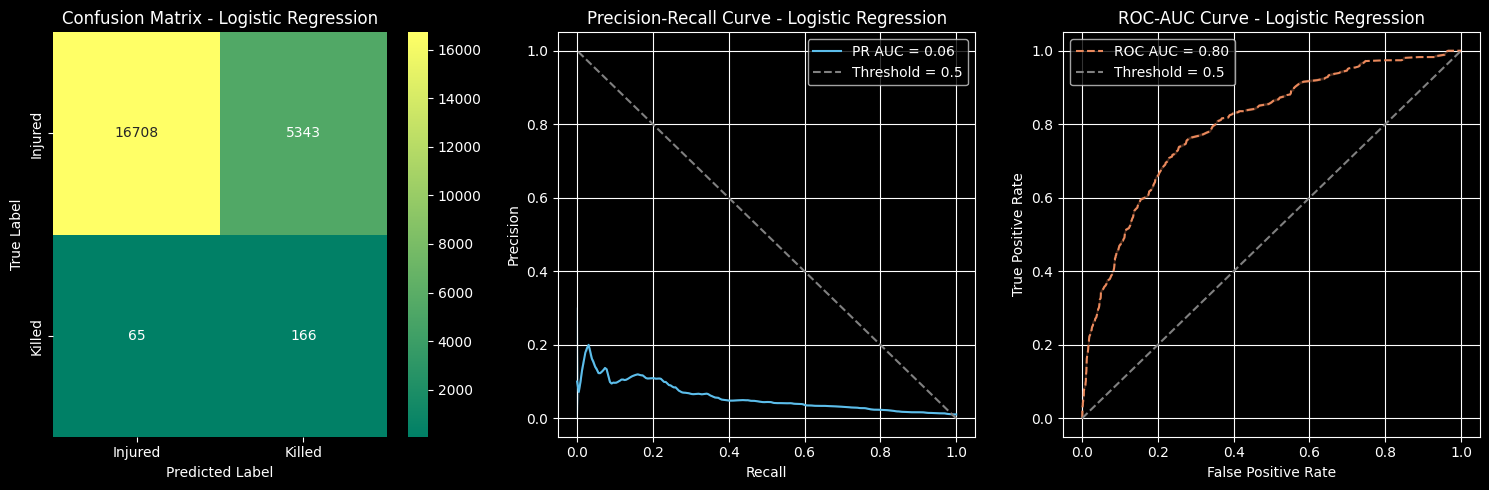

RESULTS FOR Logistic Regression
Average Precision: 0.05855643163751241
Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.76      0.72      0.86      0.74      0.55     22051
          1       0.03      0.72      0.76      0.06      0.74      0.54       231

avg / total       0.99      0.76      0.72      0.85      0.74      0.55     22282

AUC: 0.799523281428864
AUPRC: 0.057268587658743667


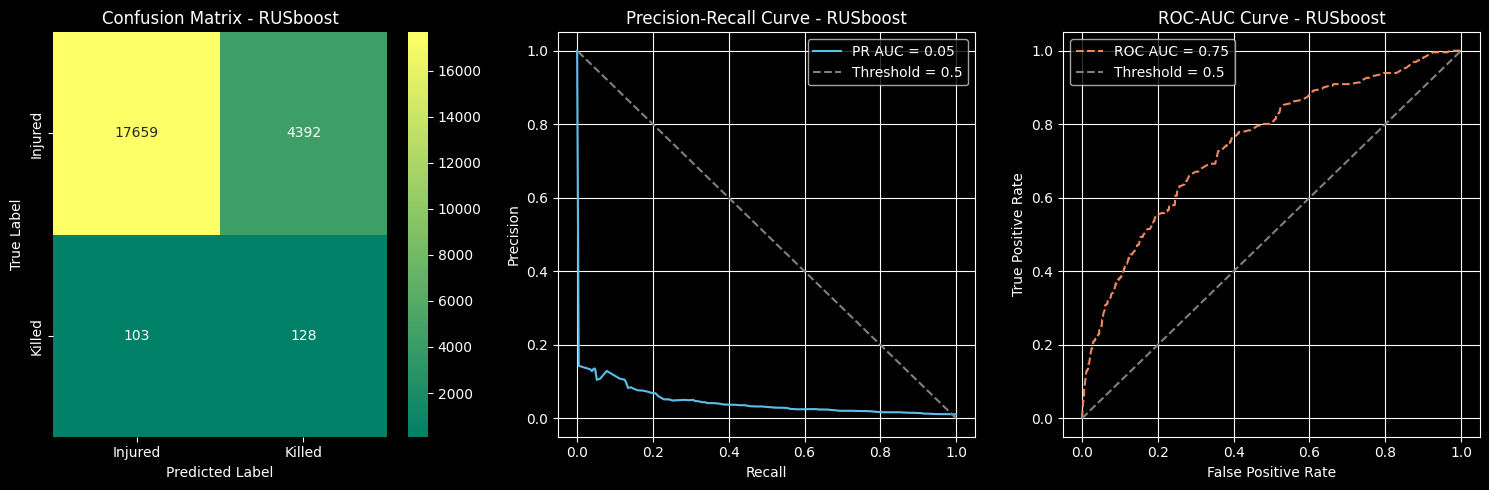

RESULTS FOR RUSboost
Average Precision: 0.04382850090284833
Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.80      0.55      0.89      0.67      0.45     22051
          1       0.03      0.55      0.80      0.05      0.67      0.43       231

avg / total       0.98      0.80      0.56      0.88      0.67      0.45     22282

AUC: 0.745472174795108
AUPRC: 0.046027992536597936


In [11]:
cat_params = {'bootstrap_type': 'Bernoulli', 'depth': 4, 'iterations': 780, 'learning_rate':0.01, 'verbose': False}
gbc_params = {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 6, 'min_samples_split': 19, 'n_estimators': 225, 'subsample': 0.9}
lr_params = {'C': 0.363, 'class_weight': 'balanced', 'max_iter': 15000, 'penalty': 'l2', 'solver': 'liblinear'}
rusboost_params = {'algorithm': 'SAMME.R', 'learning_rate': 0.021016966421157194, 'n_estimators': 213, 'replacement': False}


classifier_steps = {"CatBoost" : 
                        [('under', RandomUnderSampler(sampling_strategy=0.1, random_state=random_state)), 
                         ('over', SMOTE(random_state=random_state, sampling_strategy=0.5)), 
                         ('model', CatBoostClassifier(**cat_params))],
                    "Gradient Boosting Clf" :
                        [('under', RandomUnderSampler(sampling_strategy=0.1, random_state=random_state)), 
                         ('over', SMOTE(random_state=random_state, sampling_strategy=0.5)), 
                         ('model', GradientBoostingClassifier(**gbc_params))],
                    "Logistic Regression": 
                        [('under', RandomUnderSampler(random_state=random_state)), 
                         ('model', LogisticRegression(**lr_params))],
                    "RUSboost": 
                        [('under', RandomUnderSampler(sampling_strategy=0.1, random_state=random_state)), 
                        ('over', SMOTE(random_state=random_state, sampling_strategy=0.5)), 
                        ('model', RUSBoostClassifier(**rusboost_params))]
}
 
for name, steps in classifier_steps.items():
    pipeline = Pipeline(steps=steps)

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_scores = pipeline.predict_proba(X_test)[:, 1]

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(15, 5))
    plt.style.use('dark_background')
    #Confusion Matrix
    plt.subplot(1, 3, 1)
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="summer", xticklabels=["Injured", "Killed"], yticklabels=["Injured", "Killed"]
    )
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    #Precision Recall Curve
    plt.subplot(1, 3, 2)
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(recall, precision)
    sns.lineplot(x=recall, y=precision, label=f"PR AUC = {pr_auc:.2f}", color='#5cbdea', linestyle='-')
    plt.plot([1, 0], [0, 1], color='gray', linestyle='--', label='Threshold = 0.5')

    plt.title(f"Precision-Recall Curve - {name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid(True)

    #ROC-AUC Curve
    plt.subplot(1, 3, 3)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    sns.lineplot(x=fpr, y=tpr, label=f"ROC AUC = {roc_auc:.2f}", color='#ea895c', linestyle='--')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Threshold = 0.5')

    plt.title(f"ROC-AUC Curve - {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"RESULTS FOR {name}")
    avg_prec = average_precision_score(y_test, y_scores)
    confusion = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    imbalanced_report = classification_report_imbalanced(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_scores)
    auprc = auc(recall, precision)

    print(f"Average Precision: {avg_prec}")
    print(f"Imbalanced Classification Report:\n{imbalanced_report}")
    print("AUC:", roc_auc)
    print(f"AUPRC: {auprc}")

Random tuning failed to produce a superior set of parameters for Catboot, so reverted to original. Logistic Regression did improve average precision and had highest recall by far, so will focus on these two.

In [5]:
steps = [('under', RandomUnderSampler(sampling_strategy=0.1, random_state=random_state)), 
         ('over', SMOTE(random_state=random_state, sampling_strategy=0.5)), 
         ('model', CatBoostClassifier(iterations=100, depth=5, learning_rate=0.1, verbose=False))]
cat_pipeline = Pipeline(steps=steps)
cat_pipeline.fit(X_train, y_train)

y_pred = cat_pipeline.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

false_positive_indices = np.where((y_pred == 1) & (y_test == 0))[0]
false_negative_indices = np.where((y_pred == 0) & (y_test == 1))[0]

print(f"Number of False Positives: {len(false_positive_indices)}")
print(f"Number of False Negatives: {len(false_negative_indices)}")

print("False Negatives:")
for idx in false_negative_indices[:min(5, len(false_negative_indices))]:
    if idx < len(X_test):  
        print(f"Example {idx}:")
        print("Predicted Probability:", cat_pipeline.predict_proba(X_test.iloc[idx].values.reshape(1, -1))[:, 1])
        print("Actual Label:", y_test.iloc[idx])
        print("Features:", X_test.iloc[idx])
        print()


Number of False Positives: 903
Number of False Negatives: 153
False Negatives:
Example 2:
Predicted Probability: [0.1184936]
Actual Label: 1
Features: person_type                                                     0.000000
person_age                                                      1.108571
person_sex                                                      1.000000
is_weekend                                                      0.000000
is_night                                                        0.000000
near_cam                                                        0.000000
cam_distance                                                    1.041202
avg_temp                                                        0.819523
snow                                                            0.000000
rain_2.5mm                                                      0.000000
within_vz_priority                                              1.000000
near_calming                                  

In [8]:
from sklearn.model_selection import StratifiedKFold

stratified_kfold = StratifiedKFold(n_splits=25, shuffle=True, random_state=random_state)
cv_results = cross_val_score(cat_pipeline, X, y, cv=stratified_kfold, scoring='average_precision')

print("Cross Validation Results for Catboost:\n", cv_results)
print("Mean Average Precision score:", np.mean(cv_results))

Cross Validation Results for Catboost:
 [0.10600402 0.1127126  0.0582363  0.13546482 0.0736903  0.07392001
 0.11595293 0.10699979 0.10557922 0.14492101 0.08053768 0.09426167
 0.06680803 0.09340588 0.08396415 0.12118274 0.04790926 0.11995373
 0.12066606 0.17713168 0.12619306 0.11458292 0.15407236 0.08172688
 0.20574096]
Mean Average Precision score: 0.1088647211512284


In [12]:
steps = [('under', RandomUnderSampler(random_state=random_state)), 
         ('model', LogisticRegression(**lr_params))]

lr_pipeline = Pipeline(steps=steps)
cv_results = cross_val_score(lr_pipeline, X, y, cv=stratified_kfold, scoring='average_precision')
print("Cross Validation Results for Logistic Regression (Average Precision):\n", cv_results)
print("Mean Average Precision score:", np.mean(cv_results))
cv_results = cross_val_score(lr_pipeline, X, y, cv=stratified_kfold, scoring='recall')
print("Cross Validation Results for Logistic Regression (Recall):\n", cv_results)
print("Mean Recall score:", np.mean(cv_results))

Cross Validation Results for Logistic Regression (Average Precision):
 [0.07489012 0.0743649  0.07451813 0.10294264 0.1081405  0.07935763
 0.09923131 0.1136822  0.11330997 0.07207724 0.08335984 0.06766358
 0.09456351 0.08524419 0.107839   0.09335662 0.06634824 0.1214568
 0.07847099 0.15605093 0.11937741 0.10264463 0.09933635 0.1151985
 0.12344635]
Mean Average Precision score: 0.09707486298763941
Cross Validation Results for Logistic Regression (Recall):
 [0.76666667 0.70967742 0.64516129 0.5483871  0.93548387 0.77419355
 0.70967742 0.77419355 0.80645161 0.77419355 0.74193548 0.80645161
 0.67741935 0.83870968 0.64516129 0.80645161 0.67741935 0.80645161
 0.90322581 0.74193548 0.83870968 0.77419355 0.8        0.7
 0.9       ]
Mean Recall score: 0.7640860215053763


Fit the two models

In [6]:
cat = CatBoostClassifier(iterations=100, depth=5, learning_rate=0.1, verbose=False)

under = RandomUnderSampler(sampling_strategy=0.1, random_state=random_state)
over = SMOTE(sampling_strategy=0.5, random_state=random_state)
X_under, y_under = under.fit_resample(X_train, y_train)
X_resampled, y_resampled = over.fit_resample(X_under, y_under)

cat.fit(X_resampled, y_resampled)

lr_params = {'C': 0.363, 'class_weight': 'balanced', 'max_iter': 15000, 'penalty': 'l2', 'solver': 'liblinear'}
lr = LogisticRegression(**lr_params)

under_lr =  RandomUnderSampler(random_state=random_state)
X_resampled_lr, y_resampled_lr = under_lr.fit_resample(X_train, y_train)

lr.fit(X_resampled_lr, y_resampled_lr)

LogisticRegression(C=0.363, class_weight='balanced', max_iter=15000,
                   solver='liblinear')

Interpretation of Model Results
1. [Catboost](#Catboost)
2. [Logistic Regression](#LogisticRegression)

## Catboost

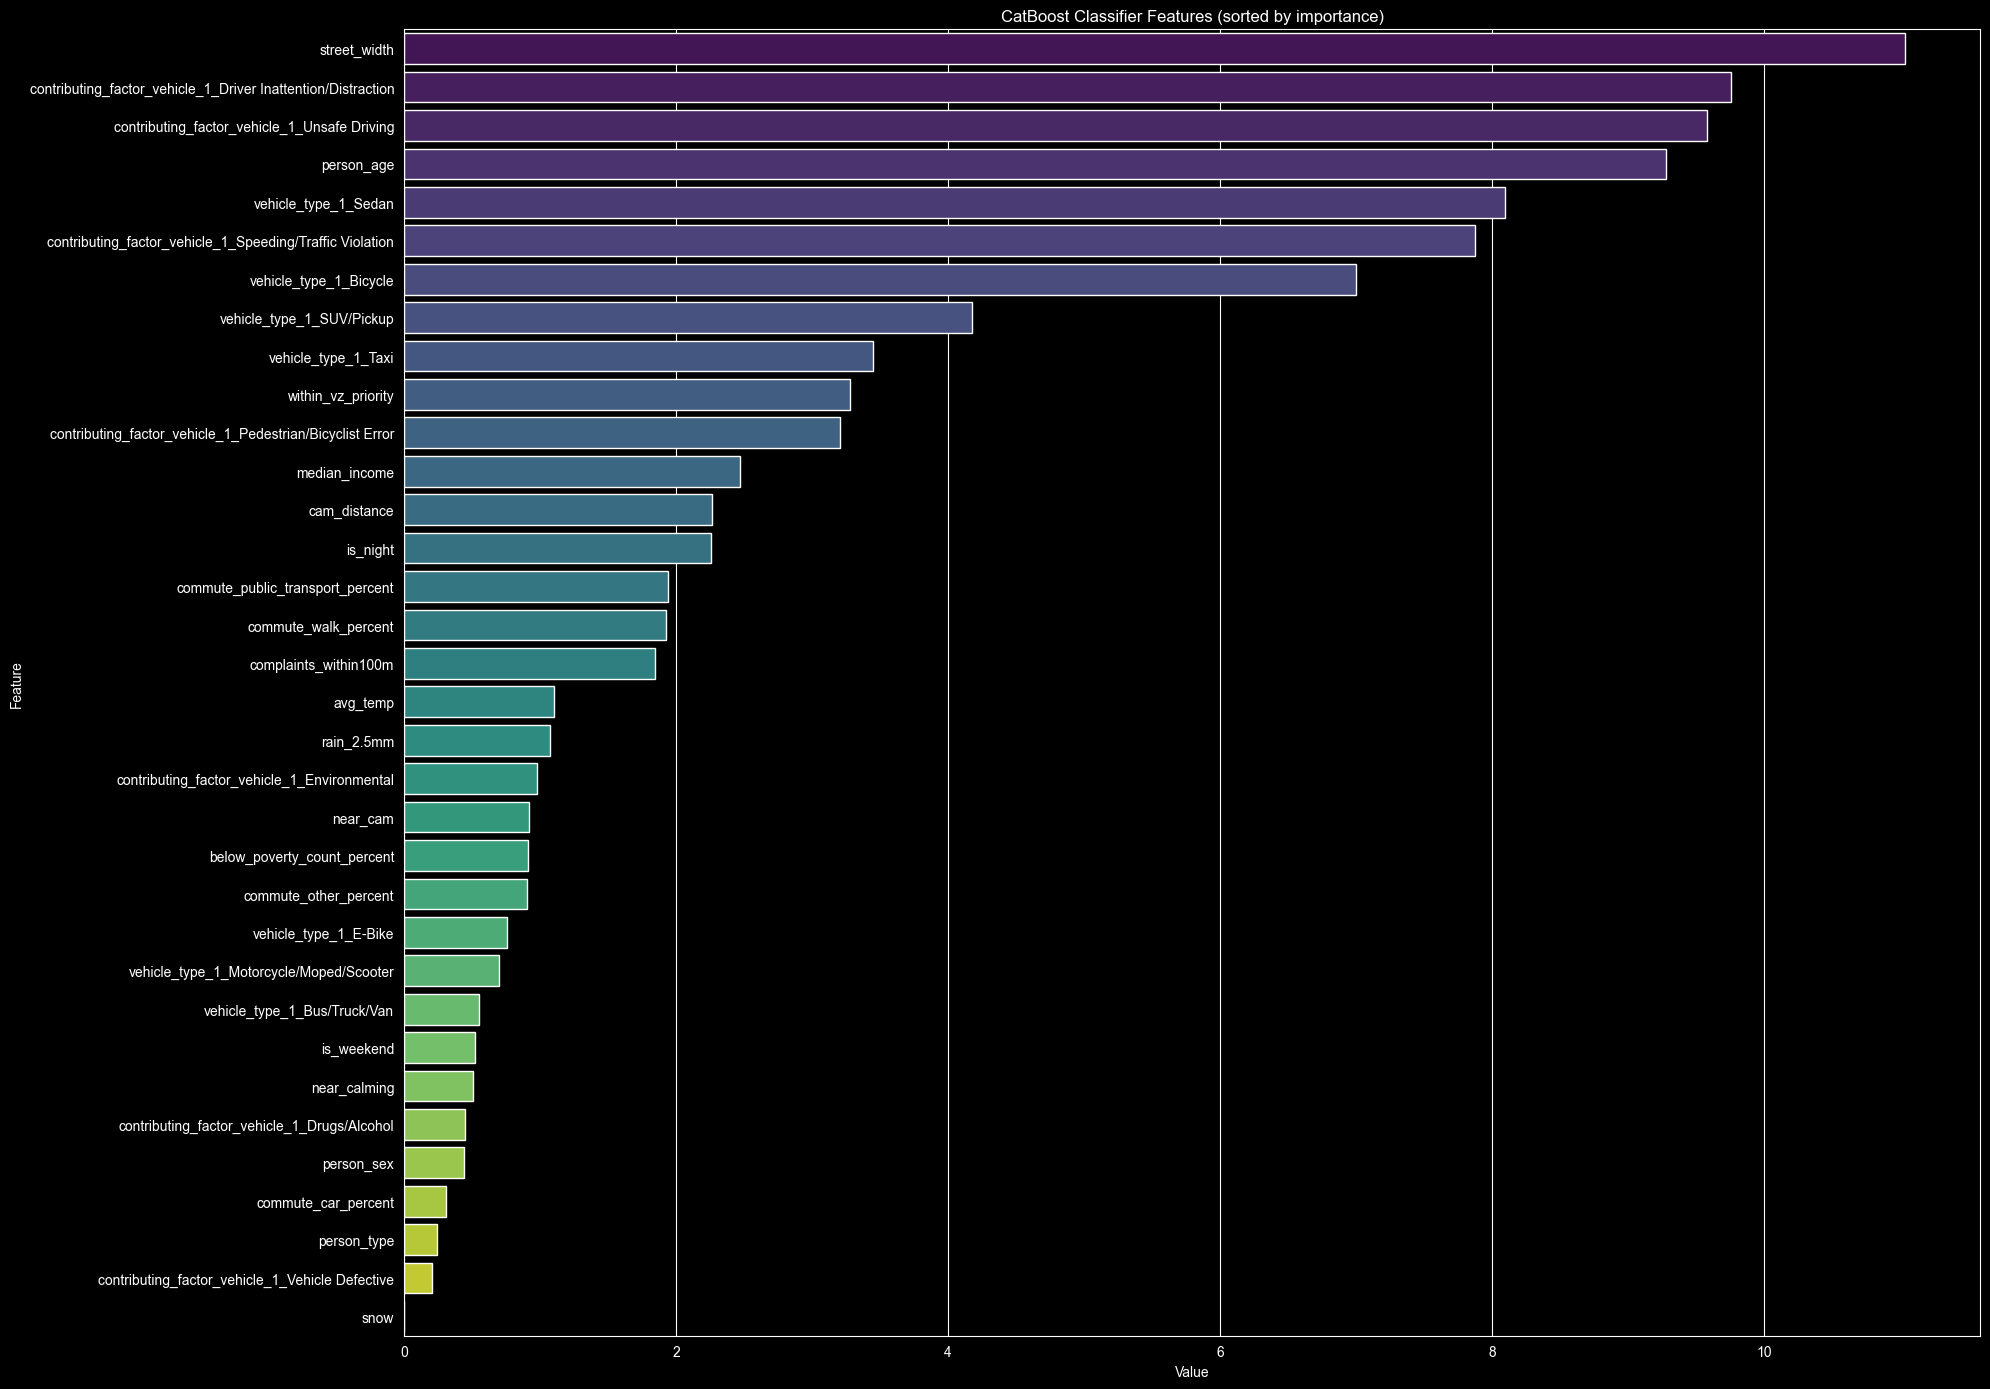

In [78]:
feature_imp_catboost = pd.DataFrame(sorted(zip(cat.get_feature_importance(), X_train.columns), reverse=True), columns=['Value', 'Feature'])

plt.figure(figsize=(20, 14))
sns.barplot(x='Value', y='Feature', data=feature_imp_catboost, palette='viridis')
plt.title('CatBoost Classifier Features (sorted by importance)')
plt.tight_layout()
plt.show()


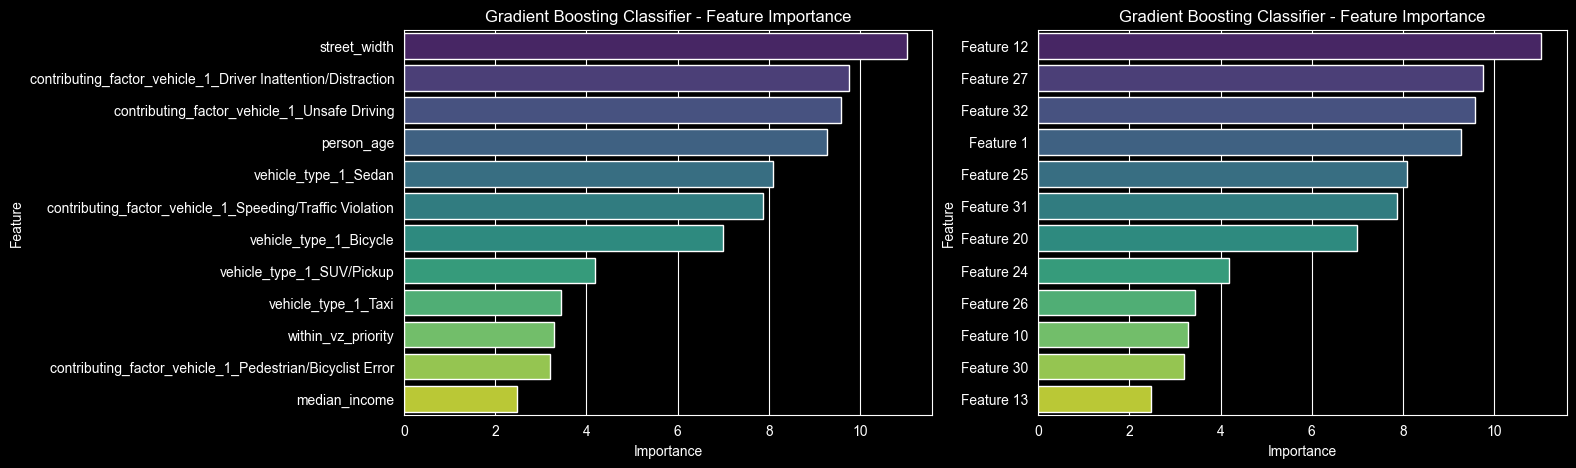

In [79]:
feature_importance = cat.feature_importances_

feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)[:12]

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Gradient Boosting Classifier - Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
feature_names = [f"Feature {i}" for i in range(X.shape[1])]
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)[:12]
plt.subplot(1,2,2)
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Gradient Boosting Classifier - Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.show()

<Figure size 640x480 with 0 Axes>

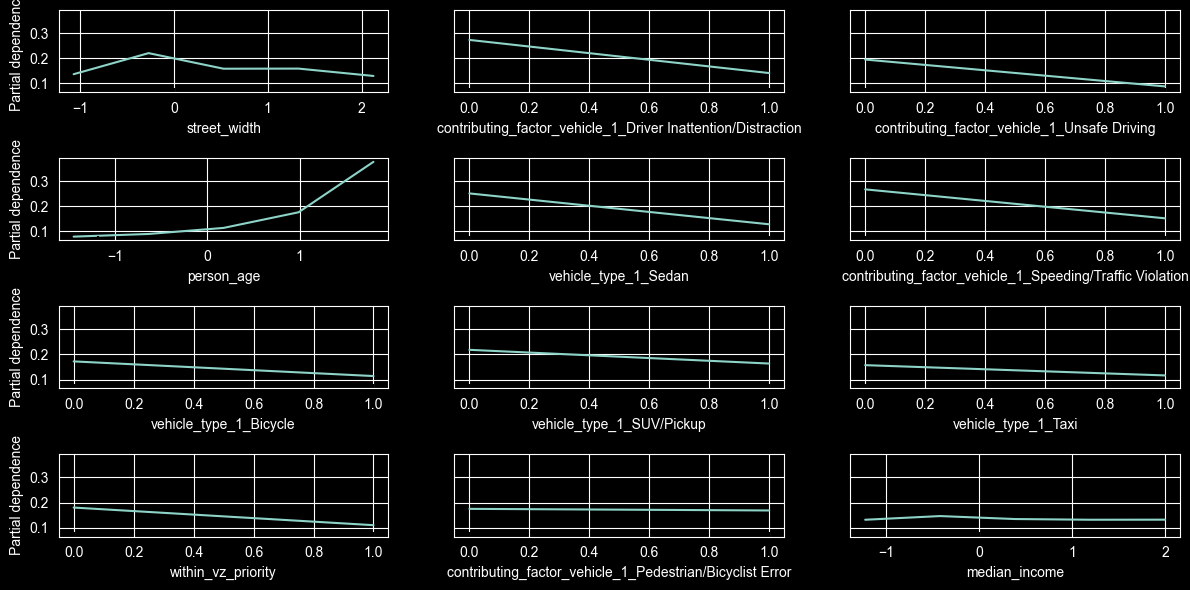

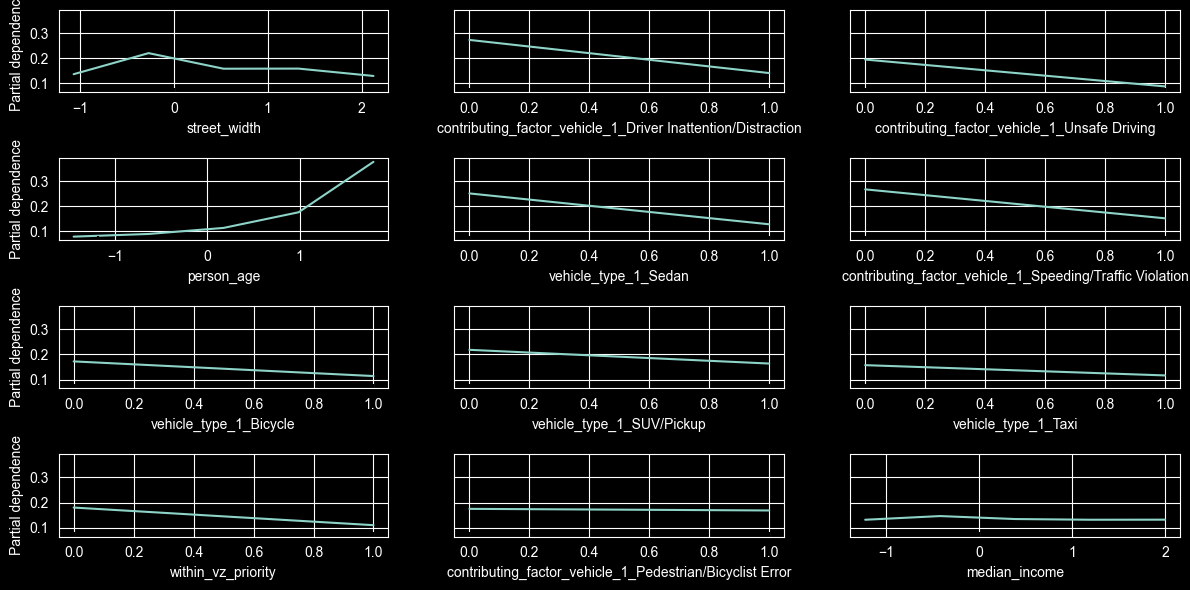

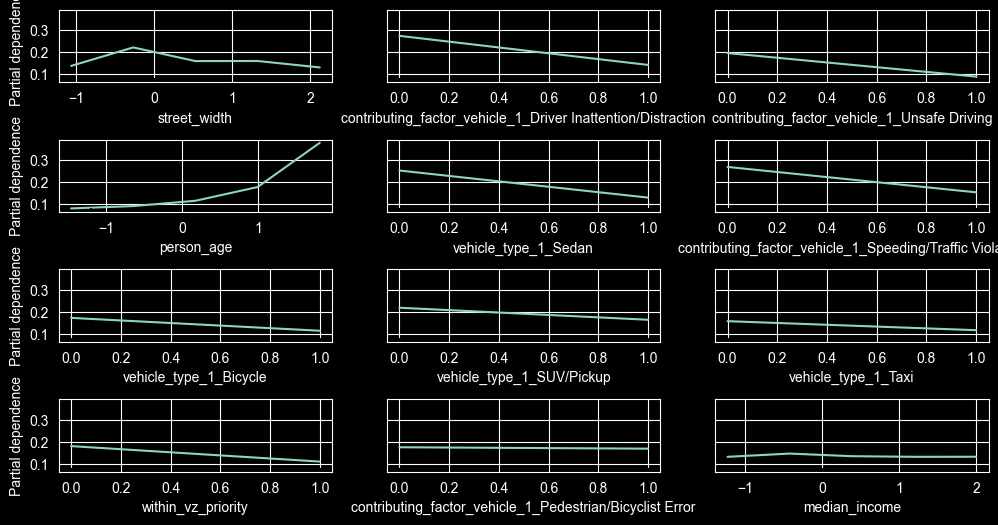

In [82]:
from sklearn.inspection import PartialDependenceDisplay

features = [12, 27, 32, 1, 25, 31, 20, 24, 26, 10, 30, 13]
plt.tight_layout()
fig, ax = plt.subplots(figsize=(12, 6))
fig.subplots_adjust(hspace=0.8)
pdp = PartialDependenceDisplay.from_estimator(cat, X, features=features, grid_resolution=5, ax=ax)

plt.show()

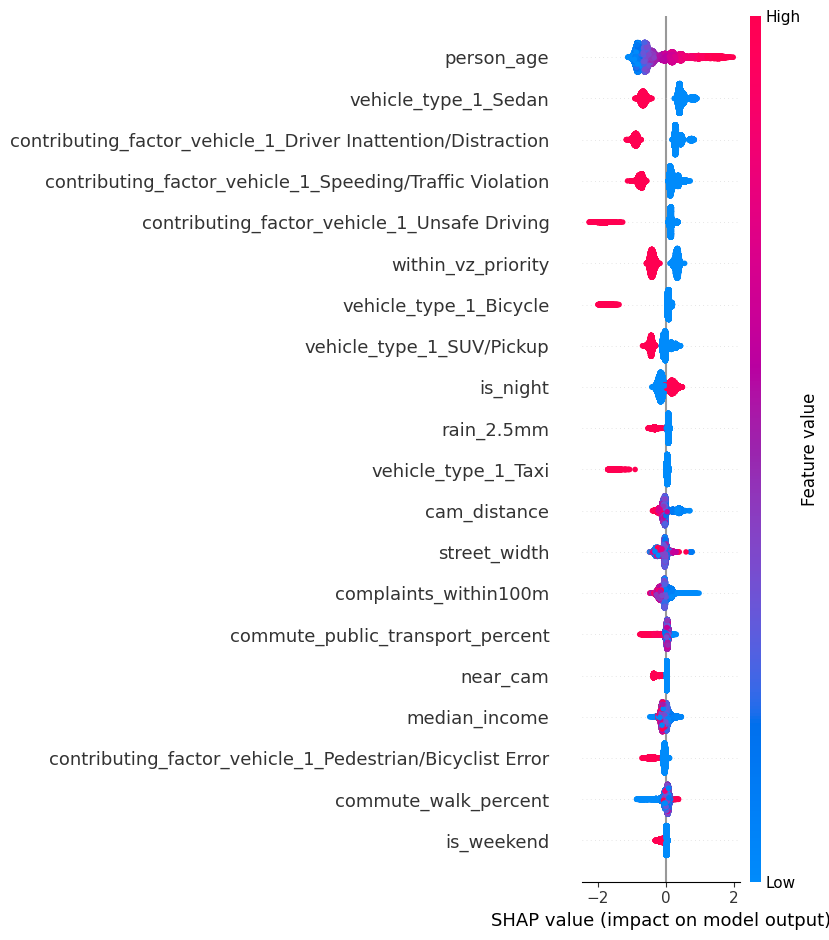

In [7]:
import shap
explainer = shap.Explainer(cat)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

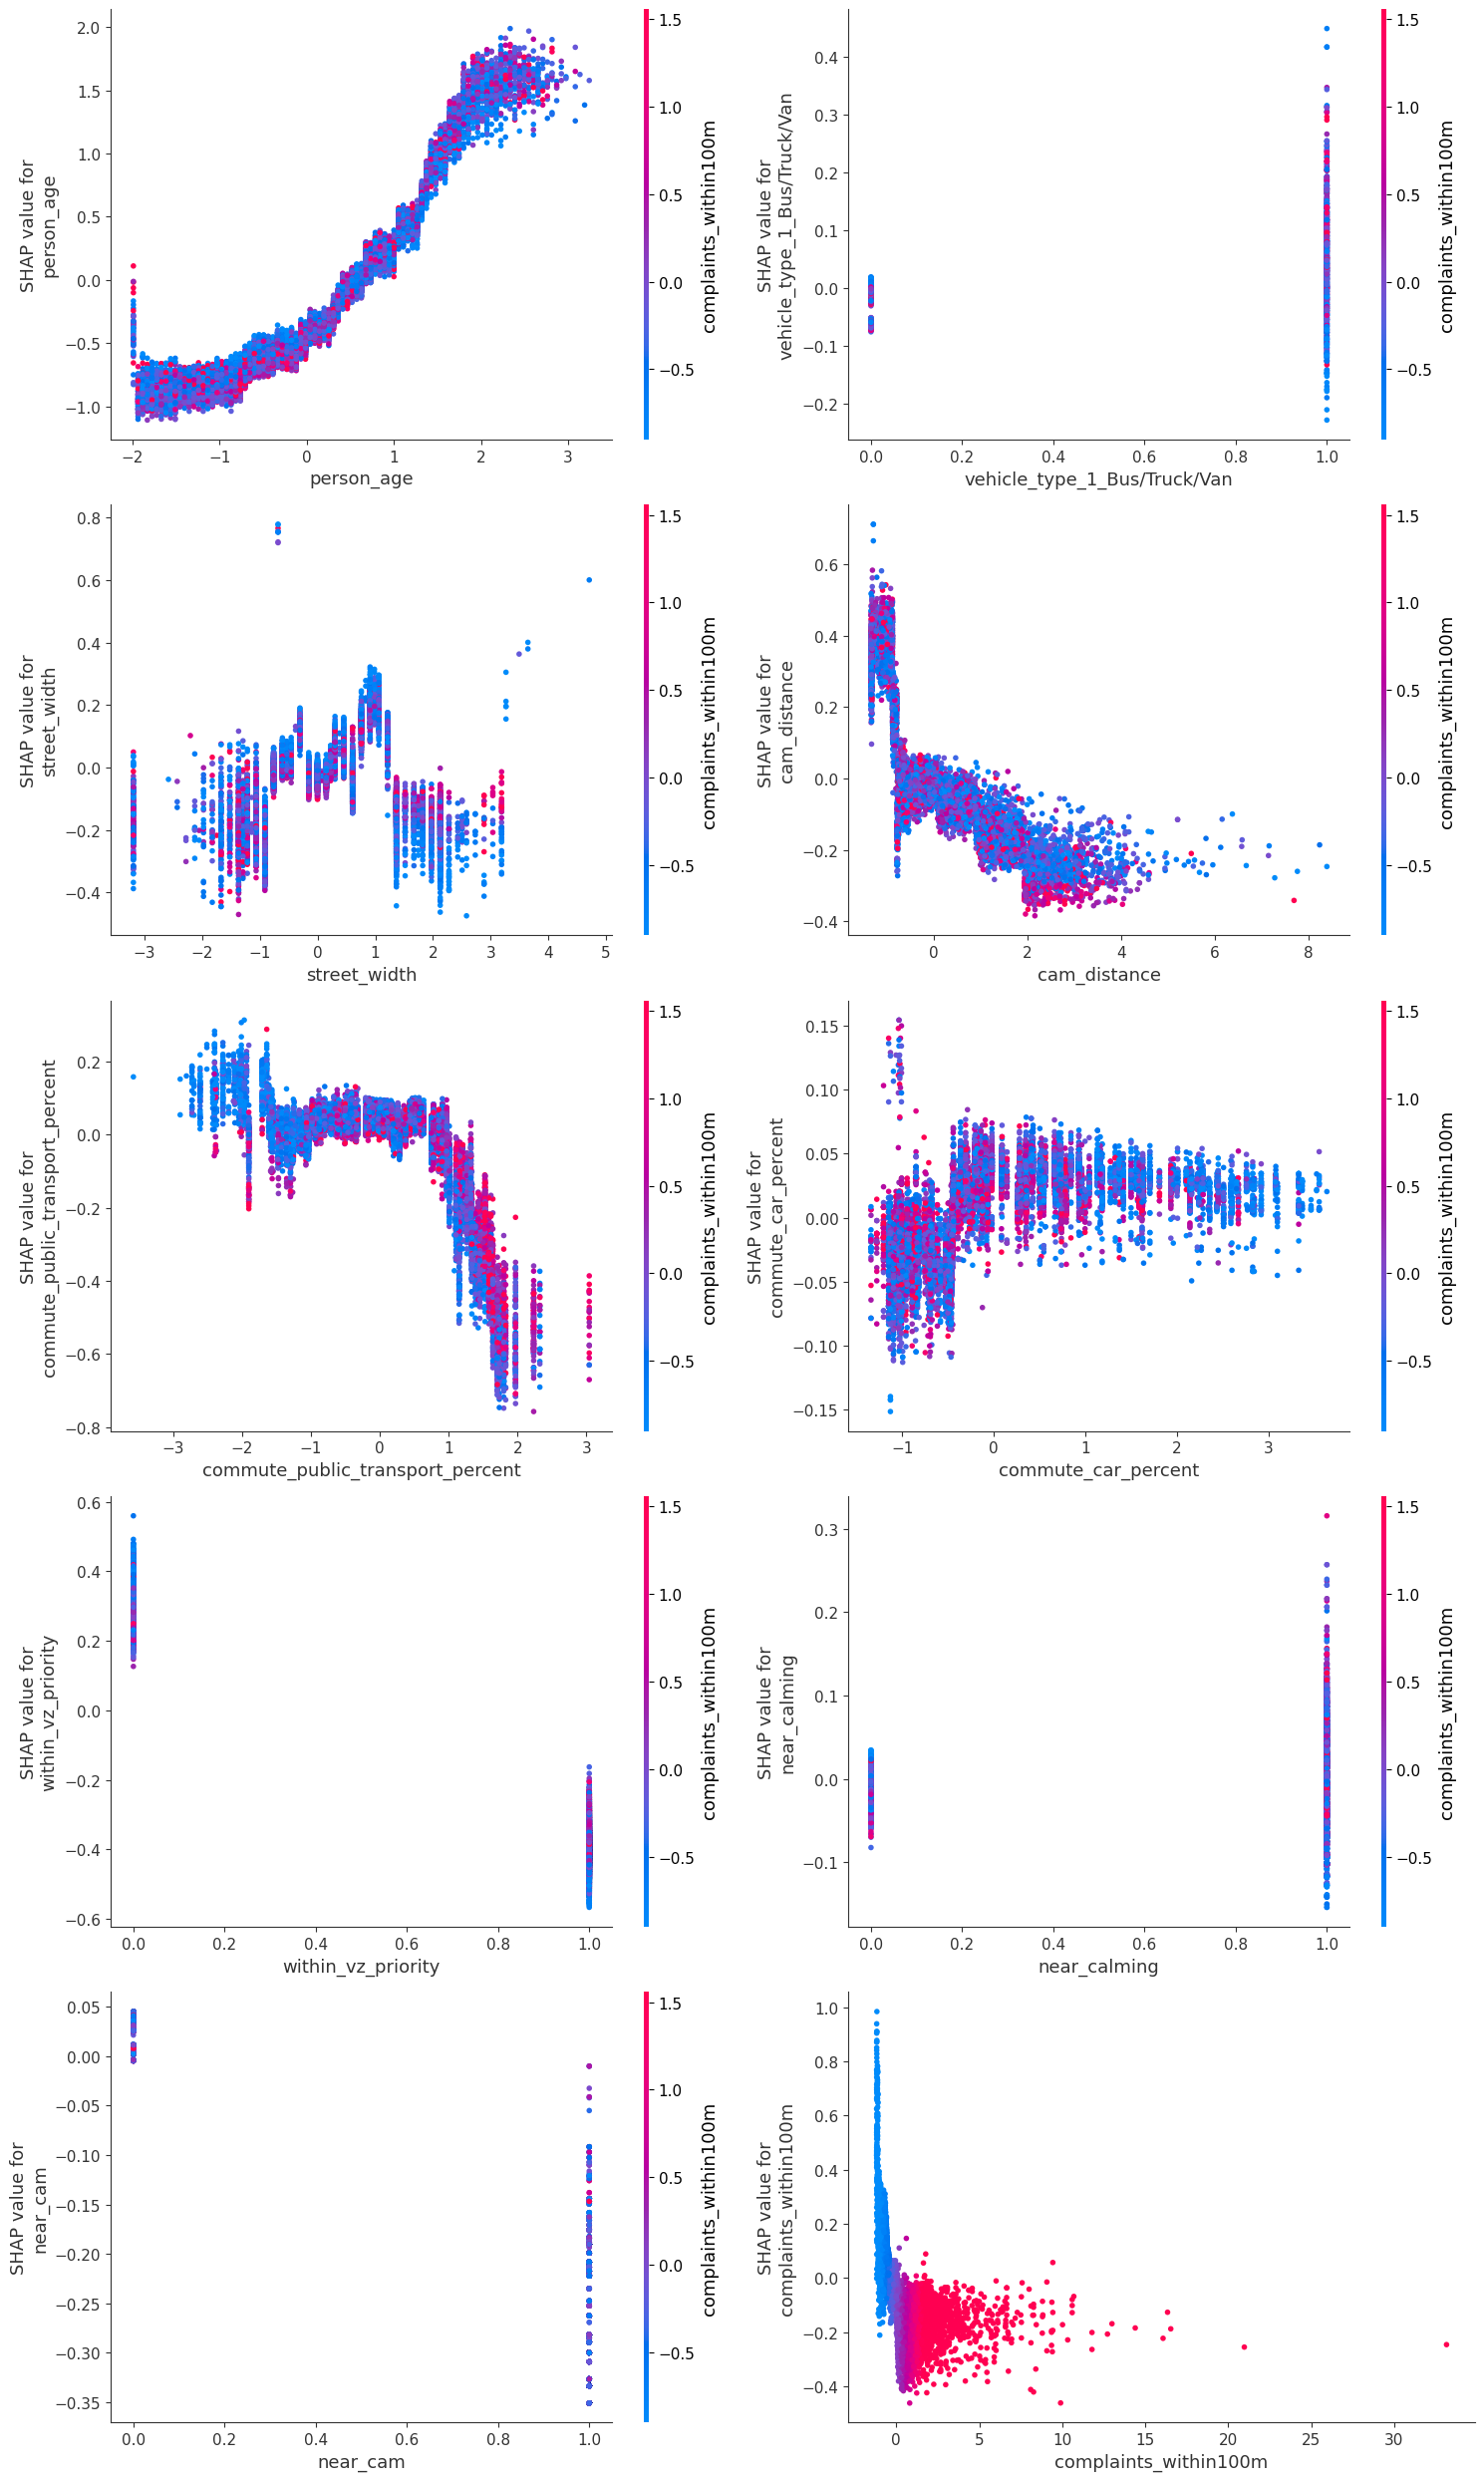

In [8]:
features_to_plot = ['person_age', 'vehicle_type_1_Bus/Truck/Van', 'street_width', 'cam_distance', 'commute_public_transport_percent', 
                    'commute_car_percent', 'within_vz_priority', 'near_calming', 'near_cam', 'complaints_within100m']

num_plots = len(features_to_plot)
num_rows = num_plots // 2 + num_plots % 2  
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, num_rows * 5))

for i, feature in enumerate(features_to_plot):
    row, col = divmod(i, 2)  
    shap.dependence_plot(feature, shap_values, X_test, ax=axes[row, col], show=False, interaction_index='complaints_within100m')


plt.tight_layout()

plt.show()

In [85]:
shap.initjs()

shap_values = explainer(X_test)
shap.plots.force(shap_values[21700:22201])

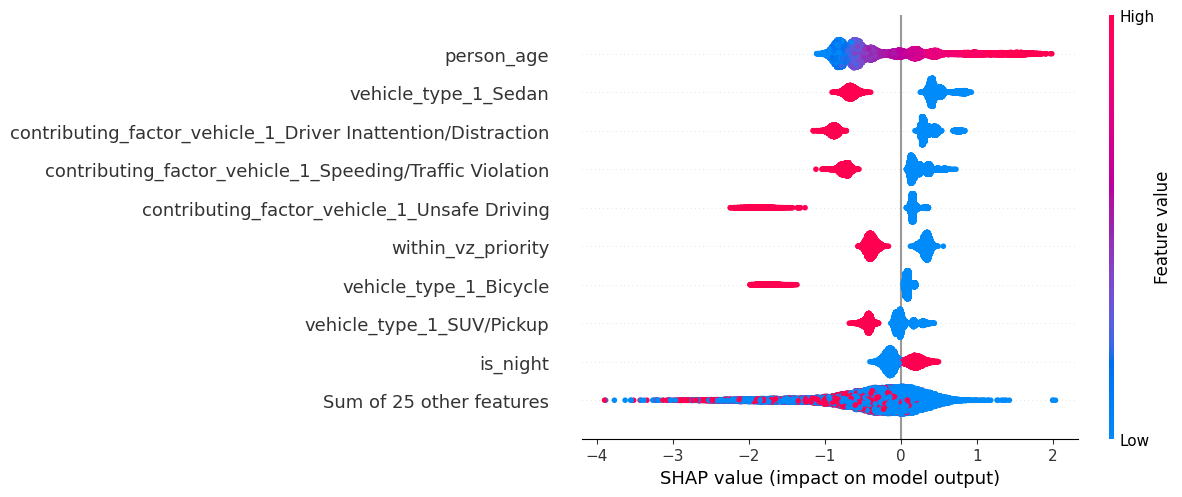

In [14]:
shap.plots.beeswarm(shap_values)

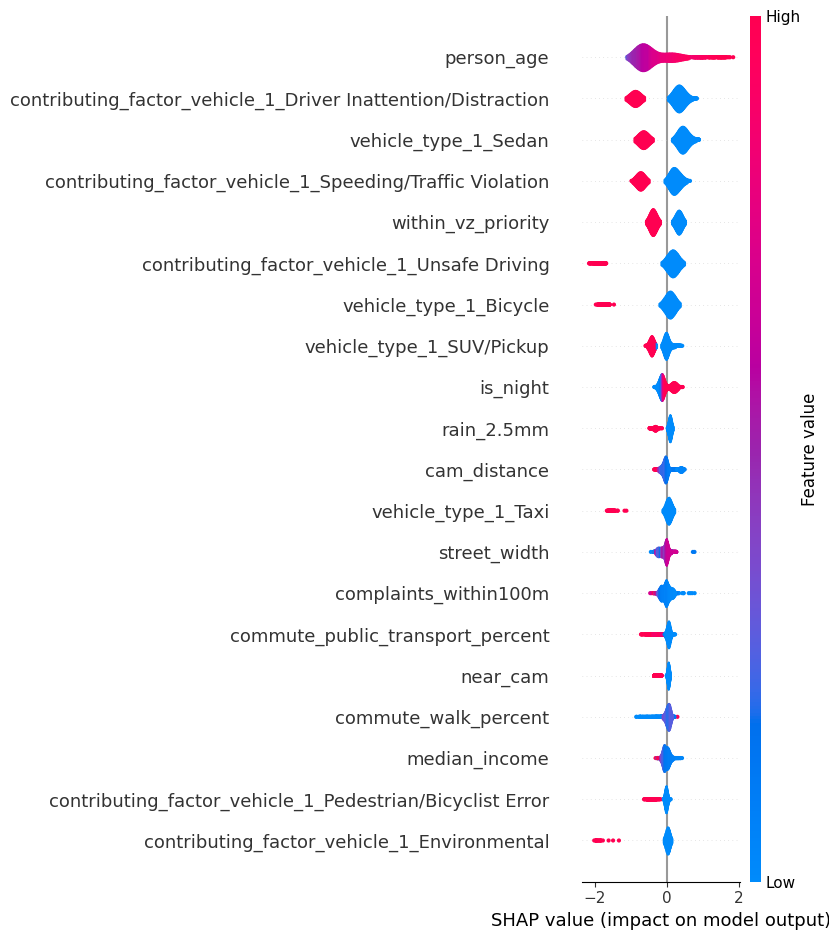

In [95]:
# Shap plot for more recent crashes
shap.summary_plot(shap_values[21000:22000, :], X_test.iloc[21000:22000, :], plot_type="violin")

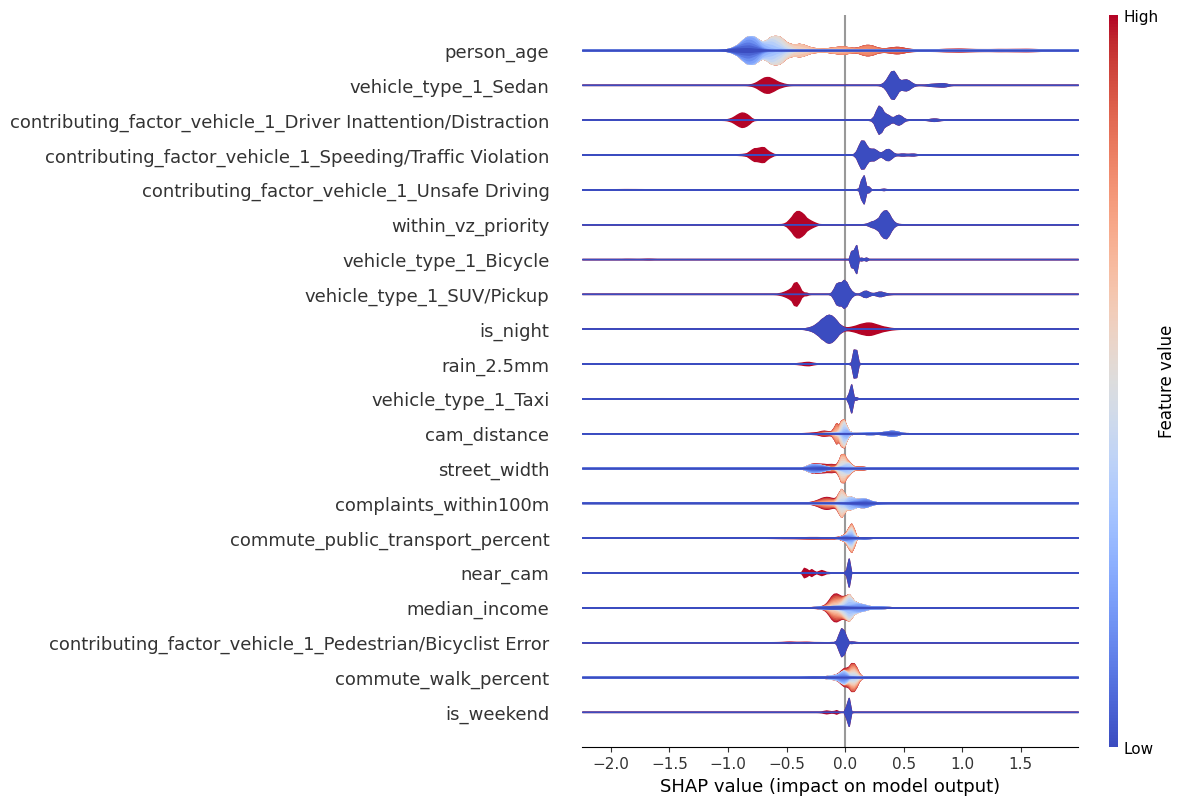

In [93]:
feat_names = list(X_test.columns)
features_of_interest = ['person_age', 'vehicle_type_1_Bus/Truck/Van', 'street_width', 'cam_distance', 'commute_public_transport_percent', 
                    'commute_car_percent', 'within_vz_priority', 'near_calming', 'near_cam', 'complaints_within100m']

#feature_indices = [X_test.columns.get_loc(feature) for feature in features_of_interest]

shap.plots.violin(shap_values, feature_names=feat_names, plot_type="layered_violin")

plt.show()

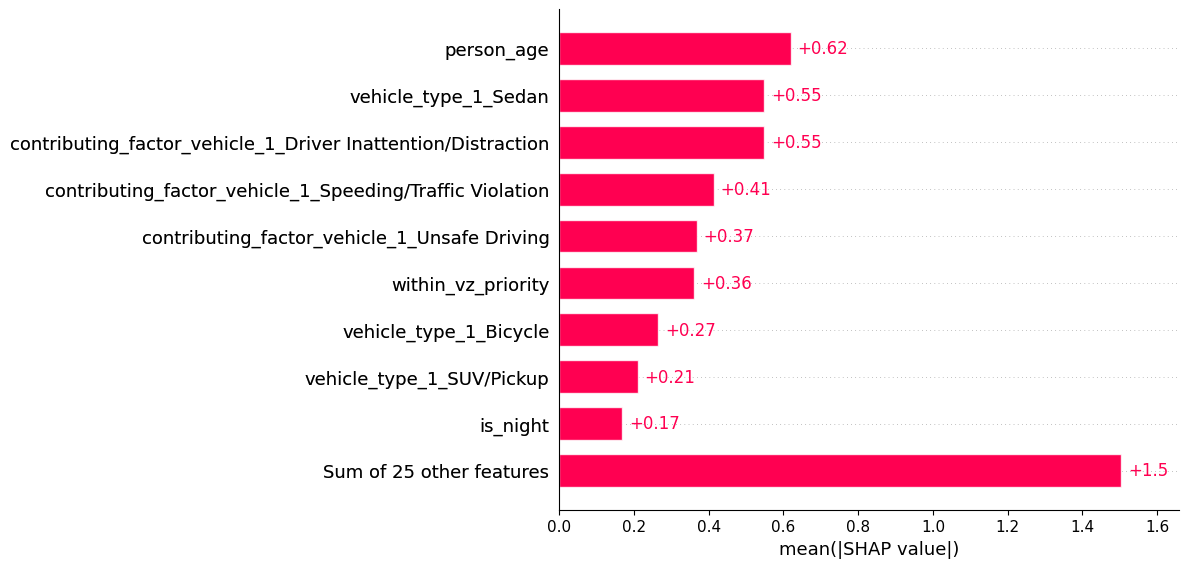

In [15]:
shap.plots.bar(shap_values)

In [24]:
correctly_predicted_indices = np.where((y_pred == 1) & (y_test == 1))[0]

print("Indices where the model correctly predicted class 1 (Killed):")
print(correctly_predicted_indices)

Indices where the model correctly predicted class 1 (Killed):
[  313   561   845  1236  1449  1521  2030  2626  2913  3272  3659  3706
  3836  4334  4994  5265  5864  6201  6384  6571  6600  6806  6844  6963
  7076  7797  7836  7847  8359  8976  9021  9027  9258  9425  9664 10223
 10294 11241 11492 12014 12722 13072 13173 13262 13698 13852 13908 14350
 14392 15081 15573 15671 16082 16566 16845 17170 17311 18093 18109 18848
 18922 19399 19431 19565 19751 19807 19817 20440 20617 20800 20855 20964
 21367 21457 21764 21895 22063 22261]


In [72]:
shap.force_plot(shap_values[20440])

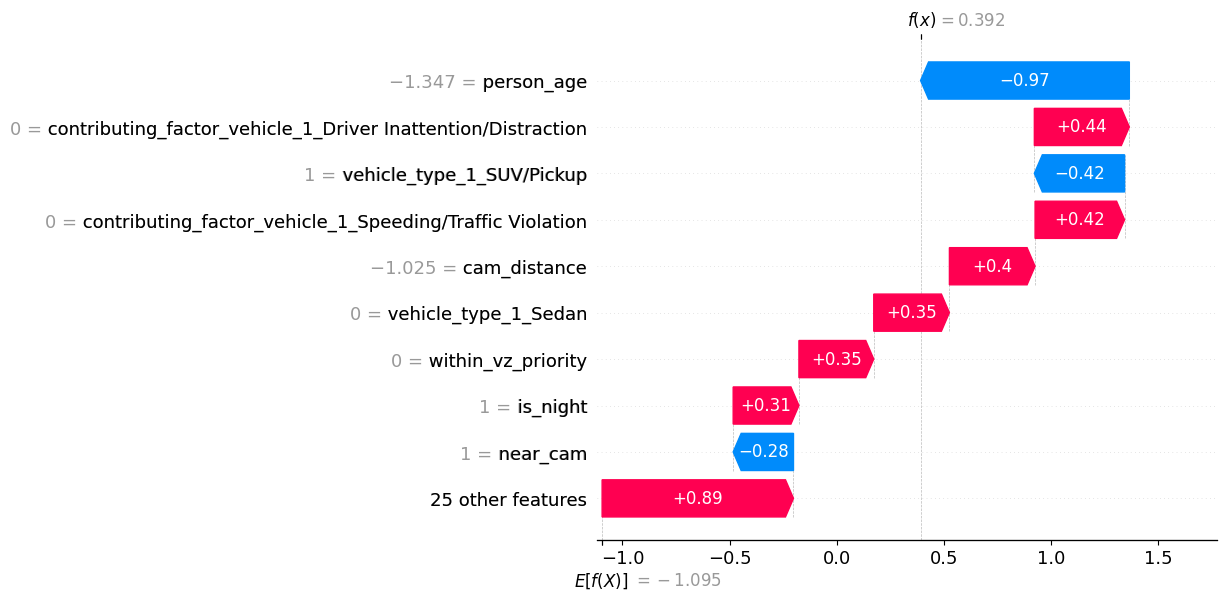

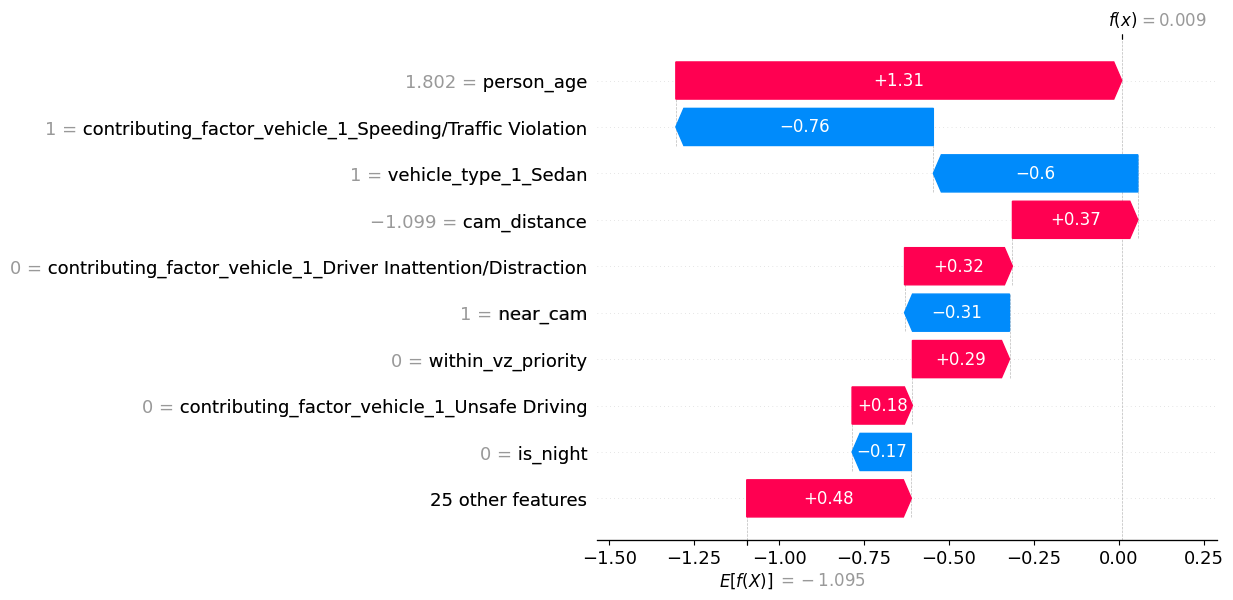

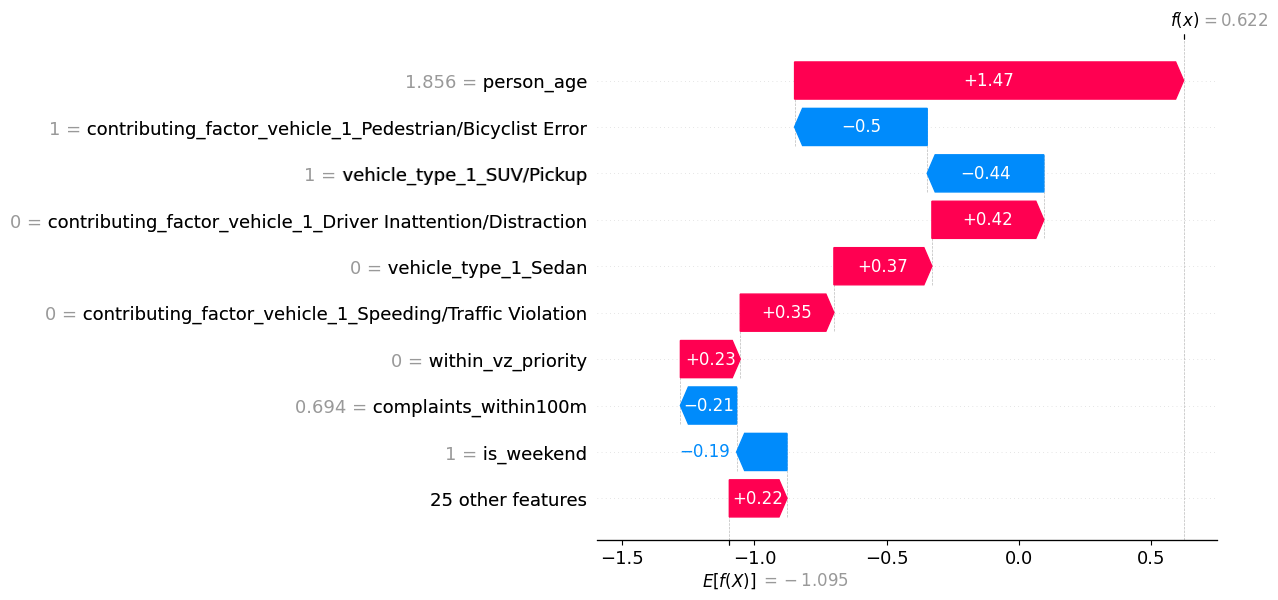

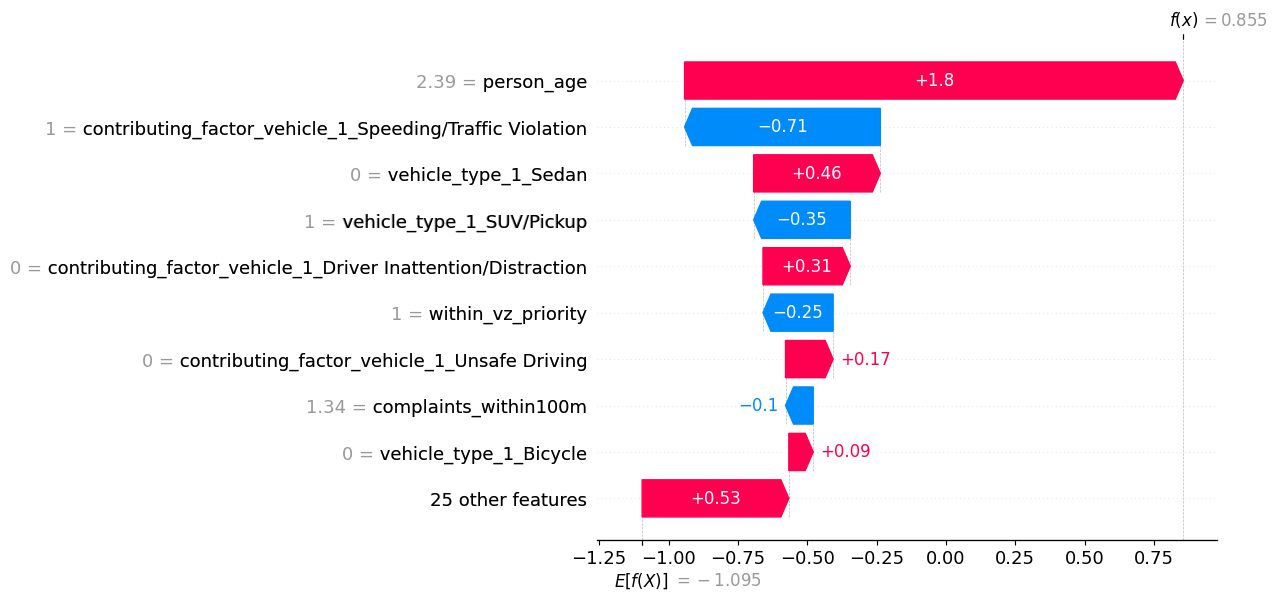

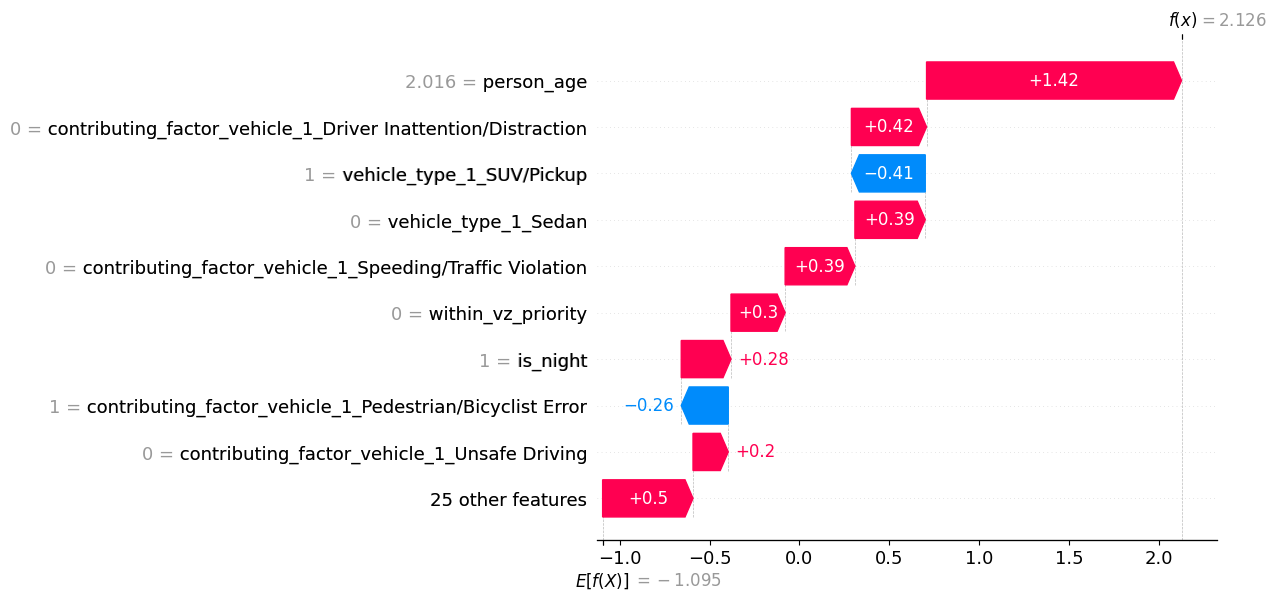

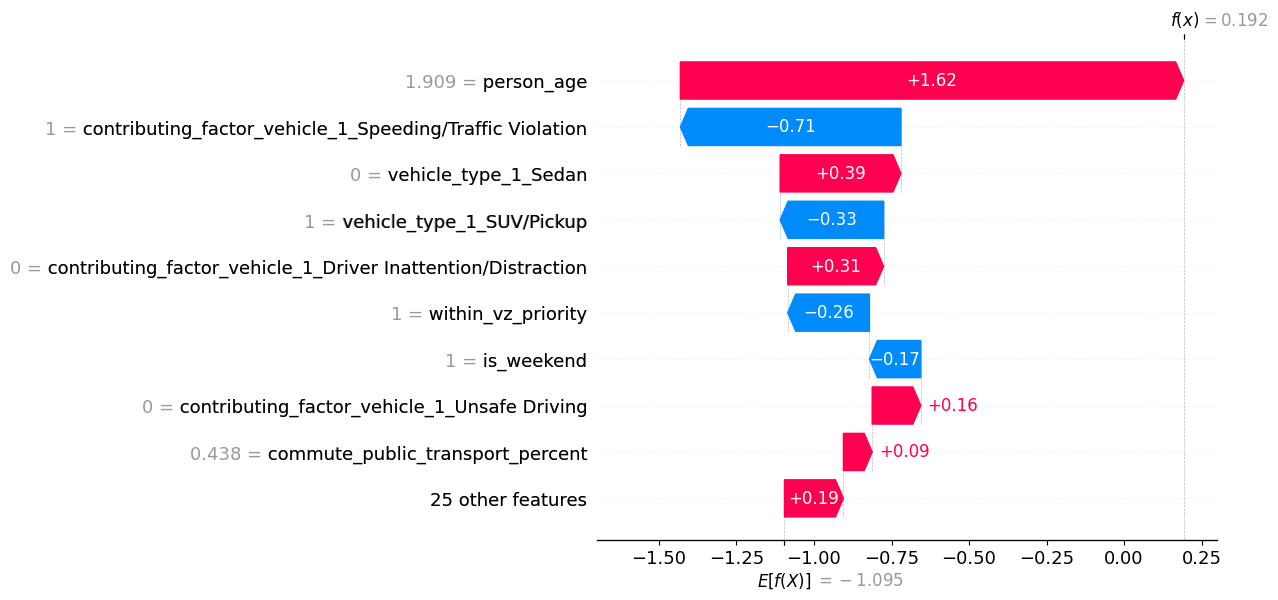

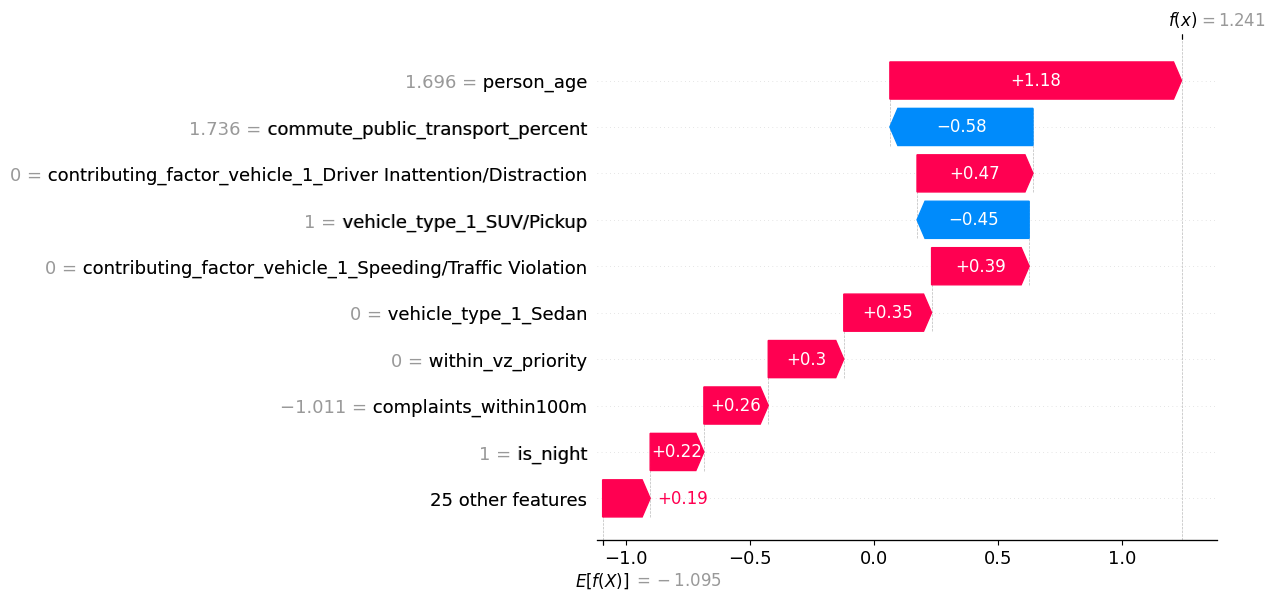

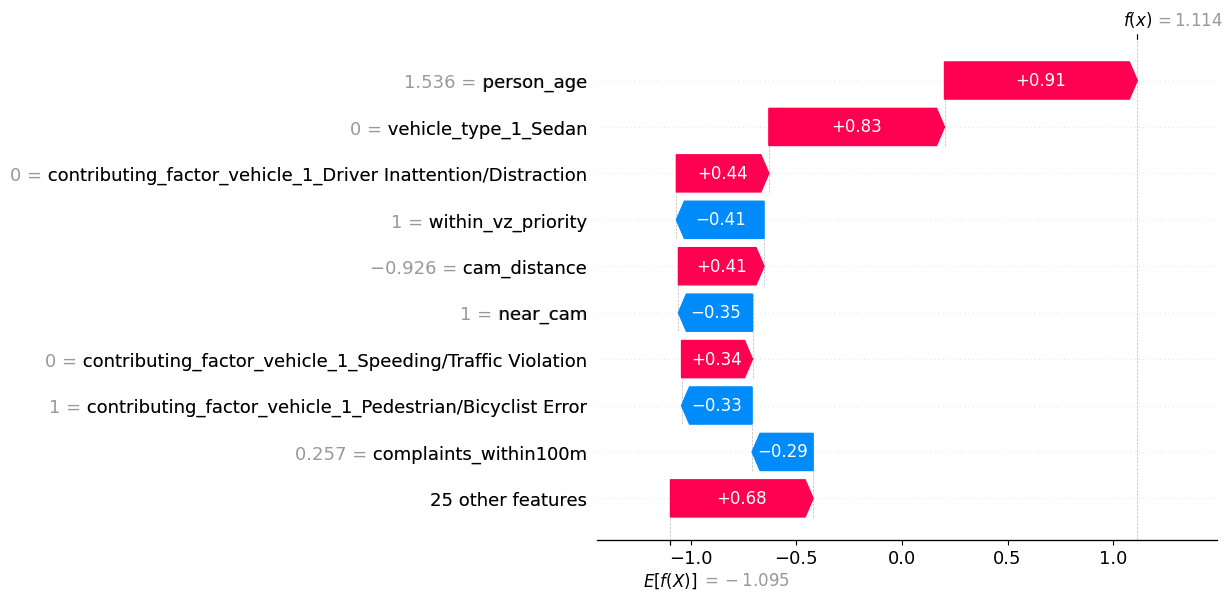

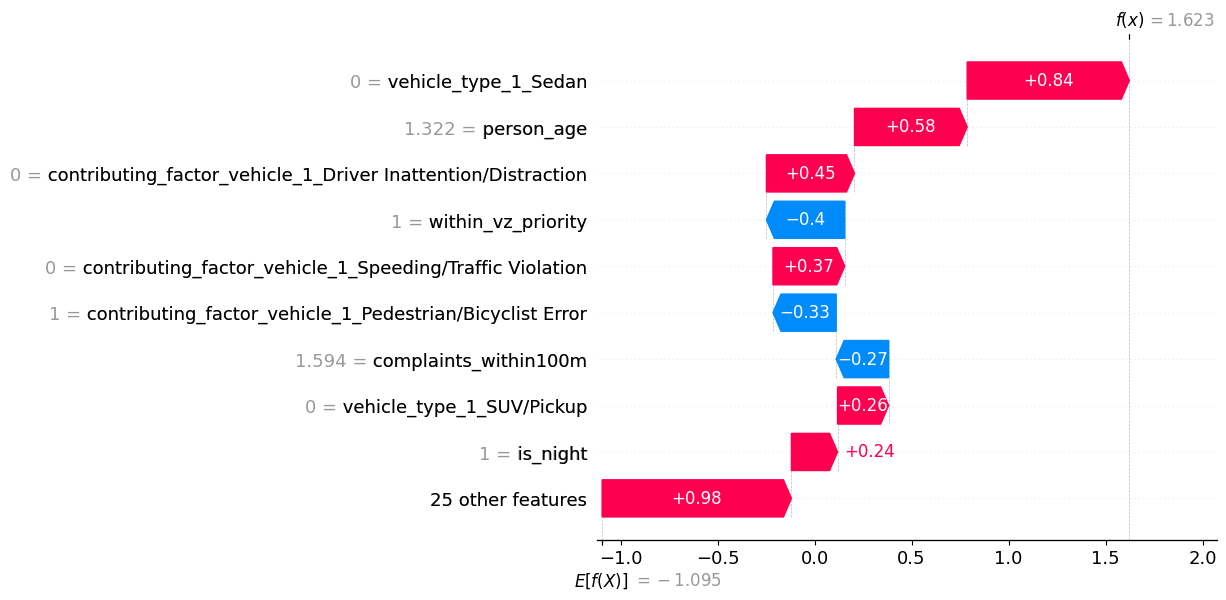

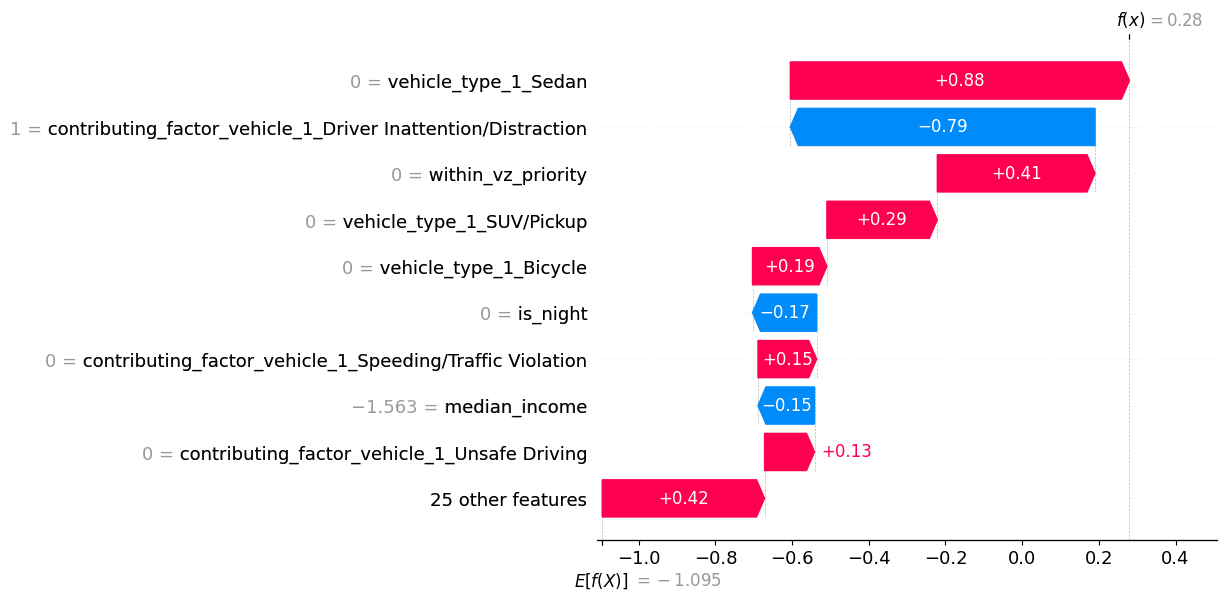

In [73]:
list_of_indices = [20617, 20800, 20855, 20964, 21367, 21457, 21764, 21895, 22063, 22261]
for i in list_of_indices:
    shap.waterfall_plot(shap_values[i])

## LogisticRegression

Intercept: [-0.88685481]


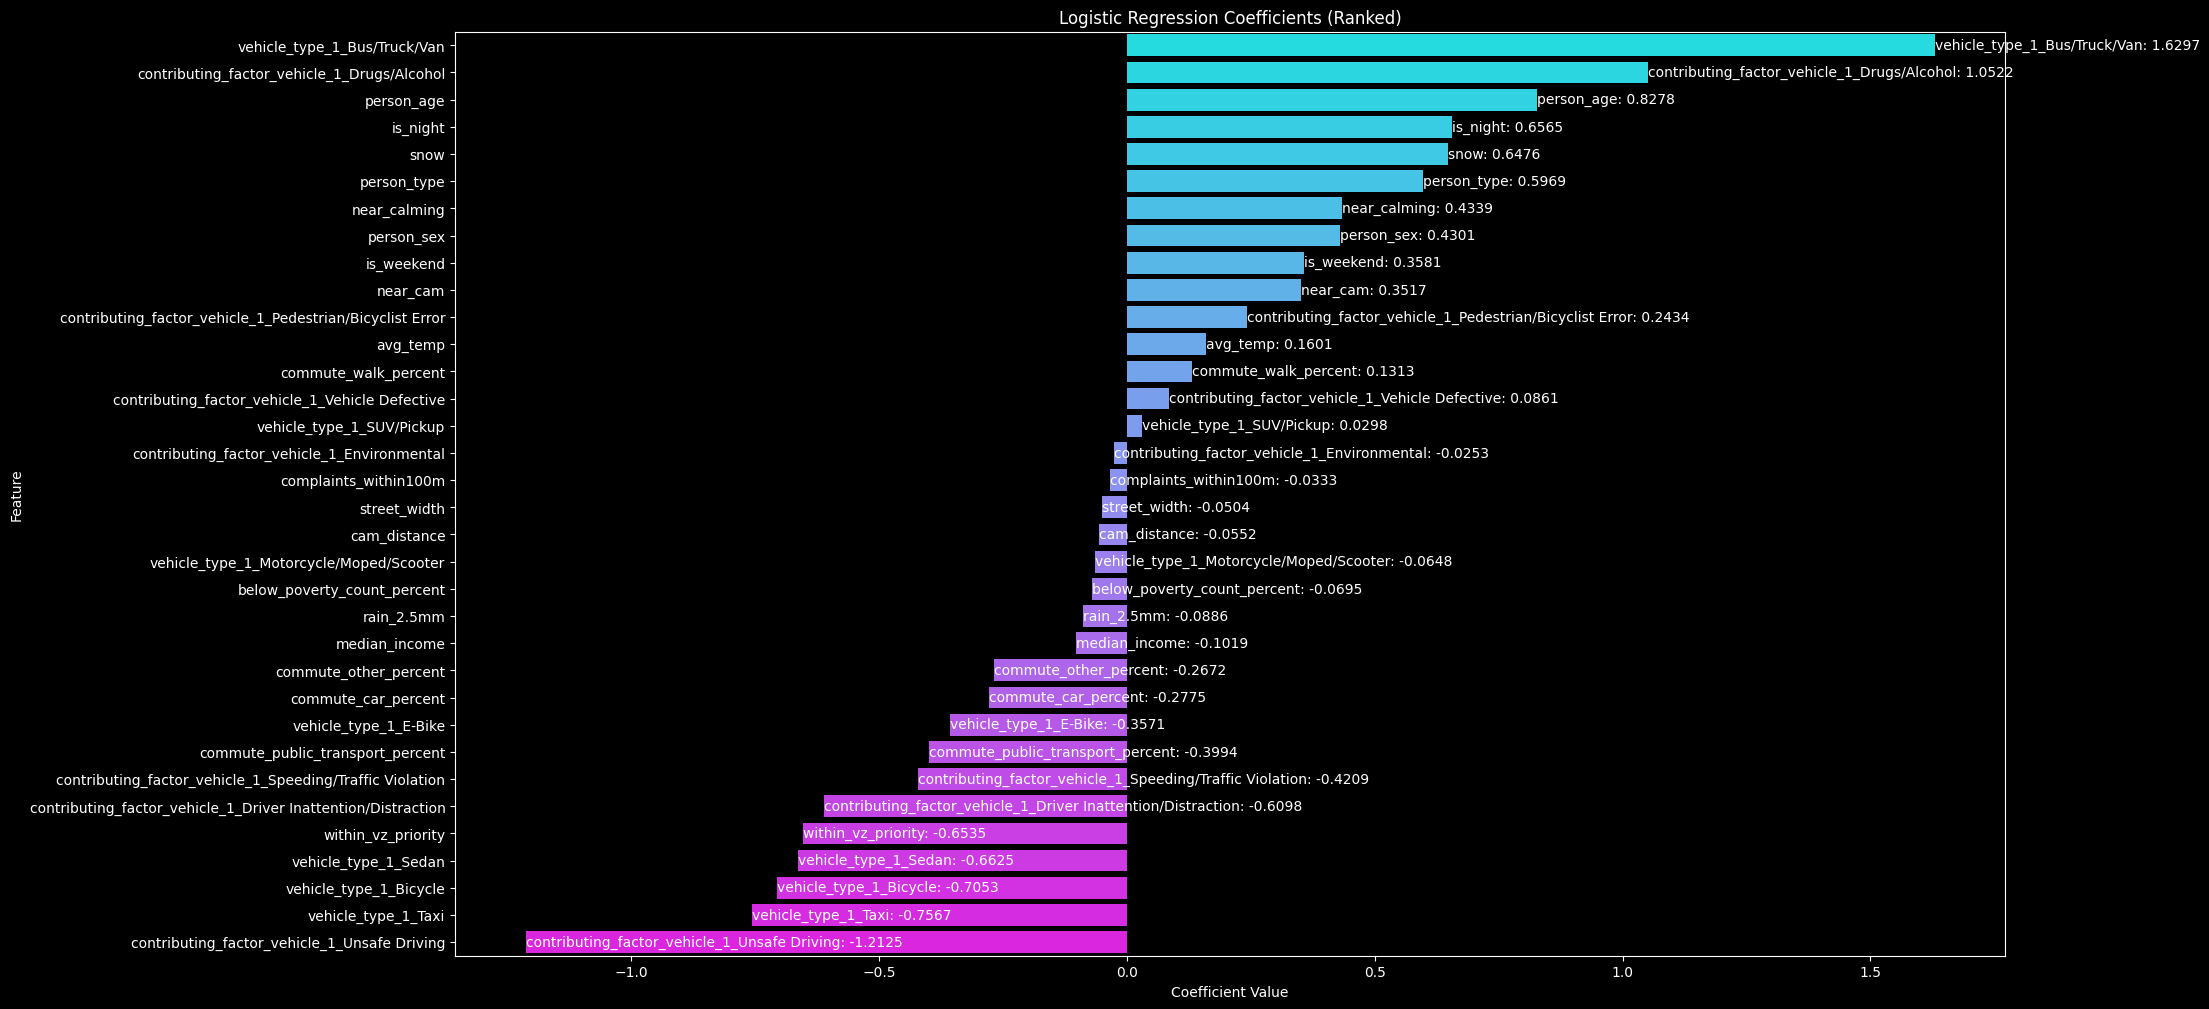

In [11]:
coefficients = lr.coef_[0]
feature_names = X.columns
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
sorted_coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
print("Intercept:", lr.intercept_)

plt.figure(figsize=(20, 12))
ax = sns.barplot(x='Coefficient', y='Feature', data=sorted_coef_df, palette='cool')

for i, (value, name) in enumerate(zip(sorted_coef_df['Coefficient'], sorted_coef_df['Feature'])):
    ax.text(value, i, f'{name}: {value:.4f}', ha='left', va='center')

plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients (Ranked)')
plt.show()

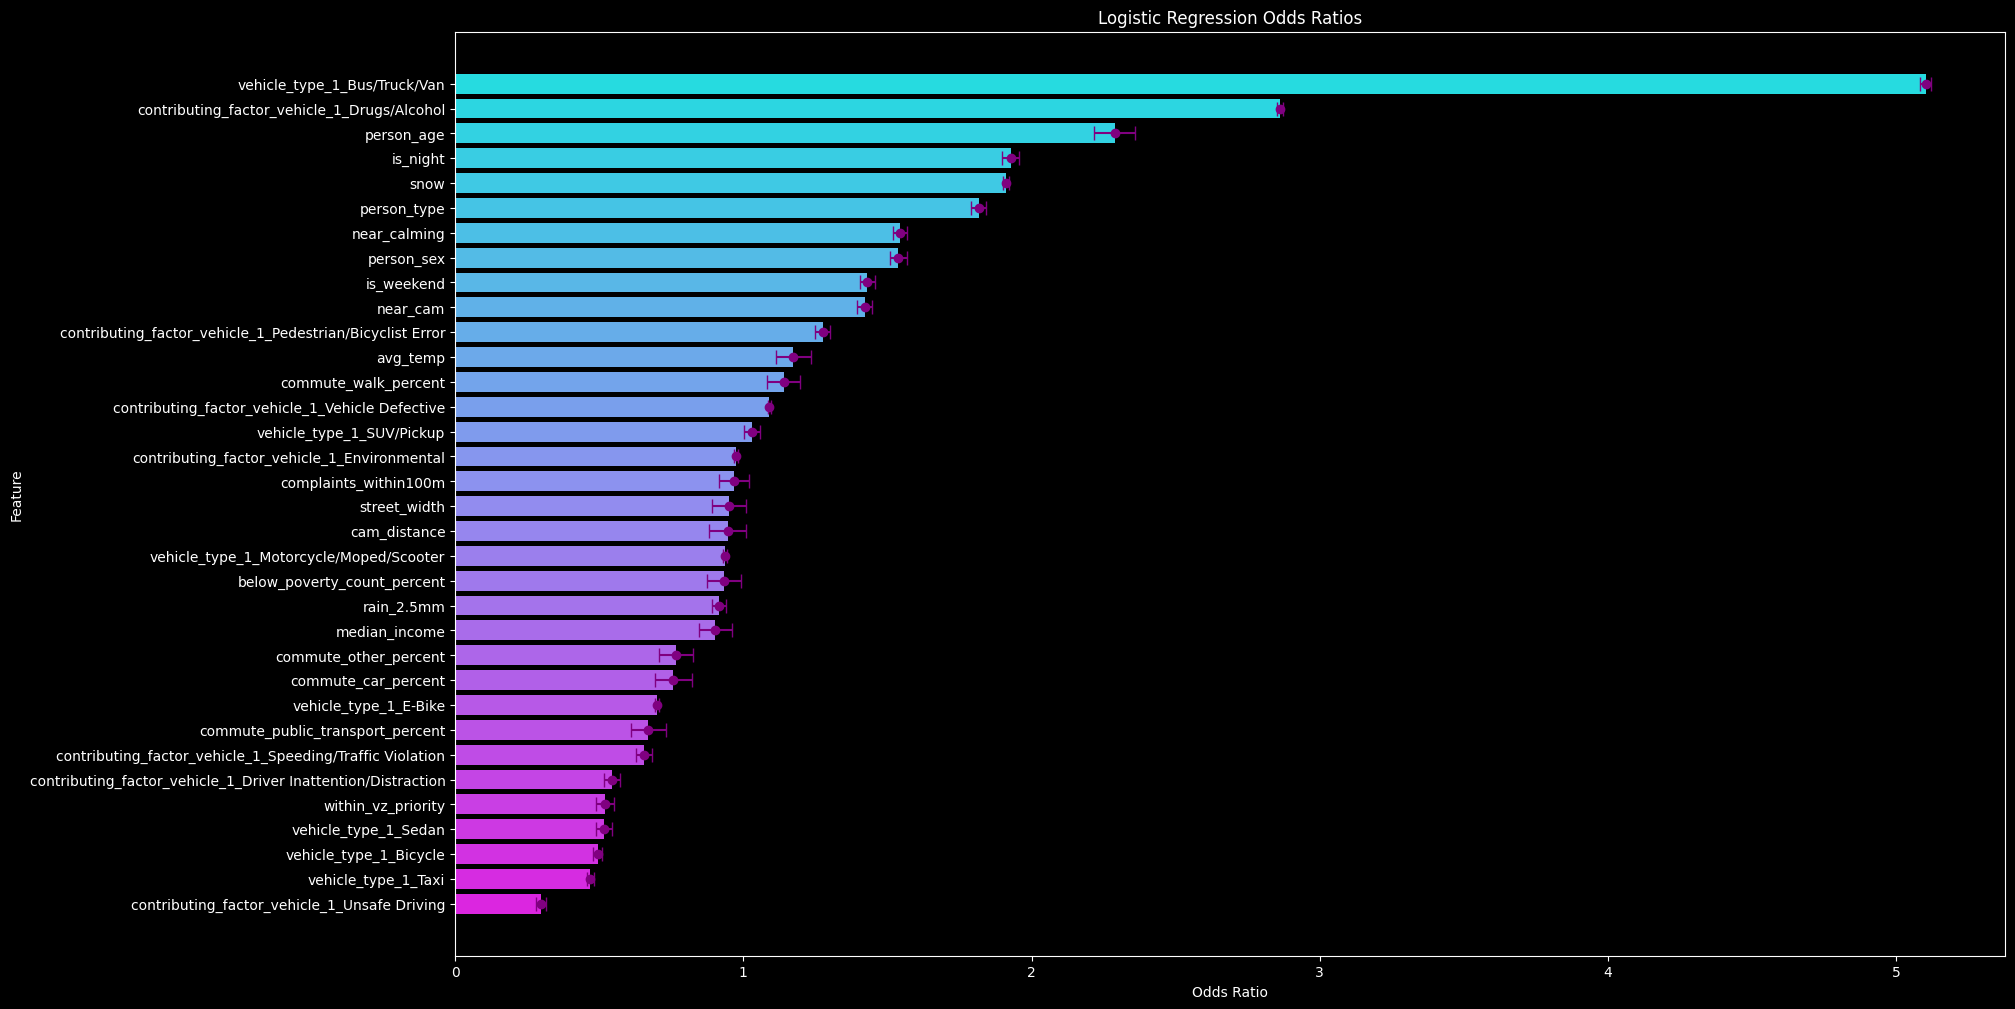

In [32]:
coefficients = lr.coef_[0]
feature_names = X.columns

se = np.std(X_resampled_lr, 0) / np.sqrt(len(X_resampled_lr))

z_score = 1.96  # 95% confidence interval
confidence_intervals = z_score * se

odds_ratios = np.exp(coefficients)

df_odds_ratios = pd.DataFrame({'Feature': feature_names, 'Odds Ratio': odds_ratios, 'Confidence Interval': confidence_intervals})
df_odds_ratios = df_odds_ratios.sort_values(by='Odds Ratio', ascending=False) 

plt.figure(figsize=(20, 12))
sns.barplot(x='Odds Ratio', y='Feature', data=df_odds_ratios, palette='cool')
plt.errorbar(x=df_odds_ratios['Odds Ratio'], y=range(len(df_odds_ratios)), xerr=df_odds_ratios['Confidence Interval'], fmt='o', capsize=5, color='purple')
plt.xlabel('Odds Ratio')
plt.title('Logistic Regression Odds Ratios')
plt.show()

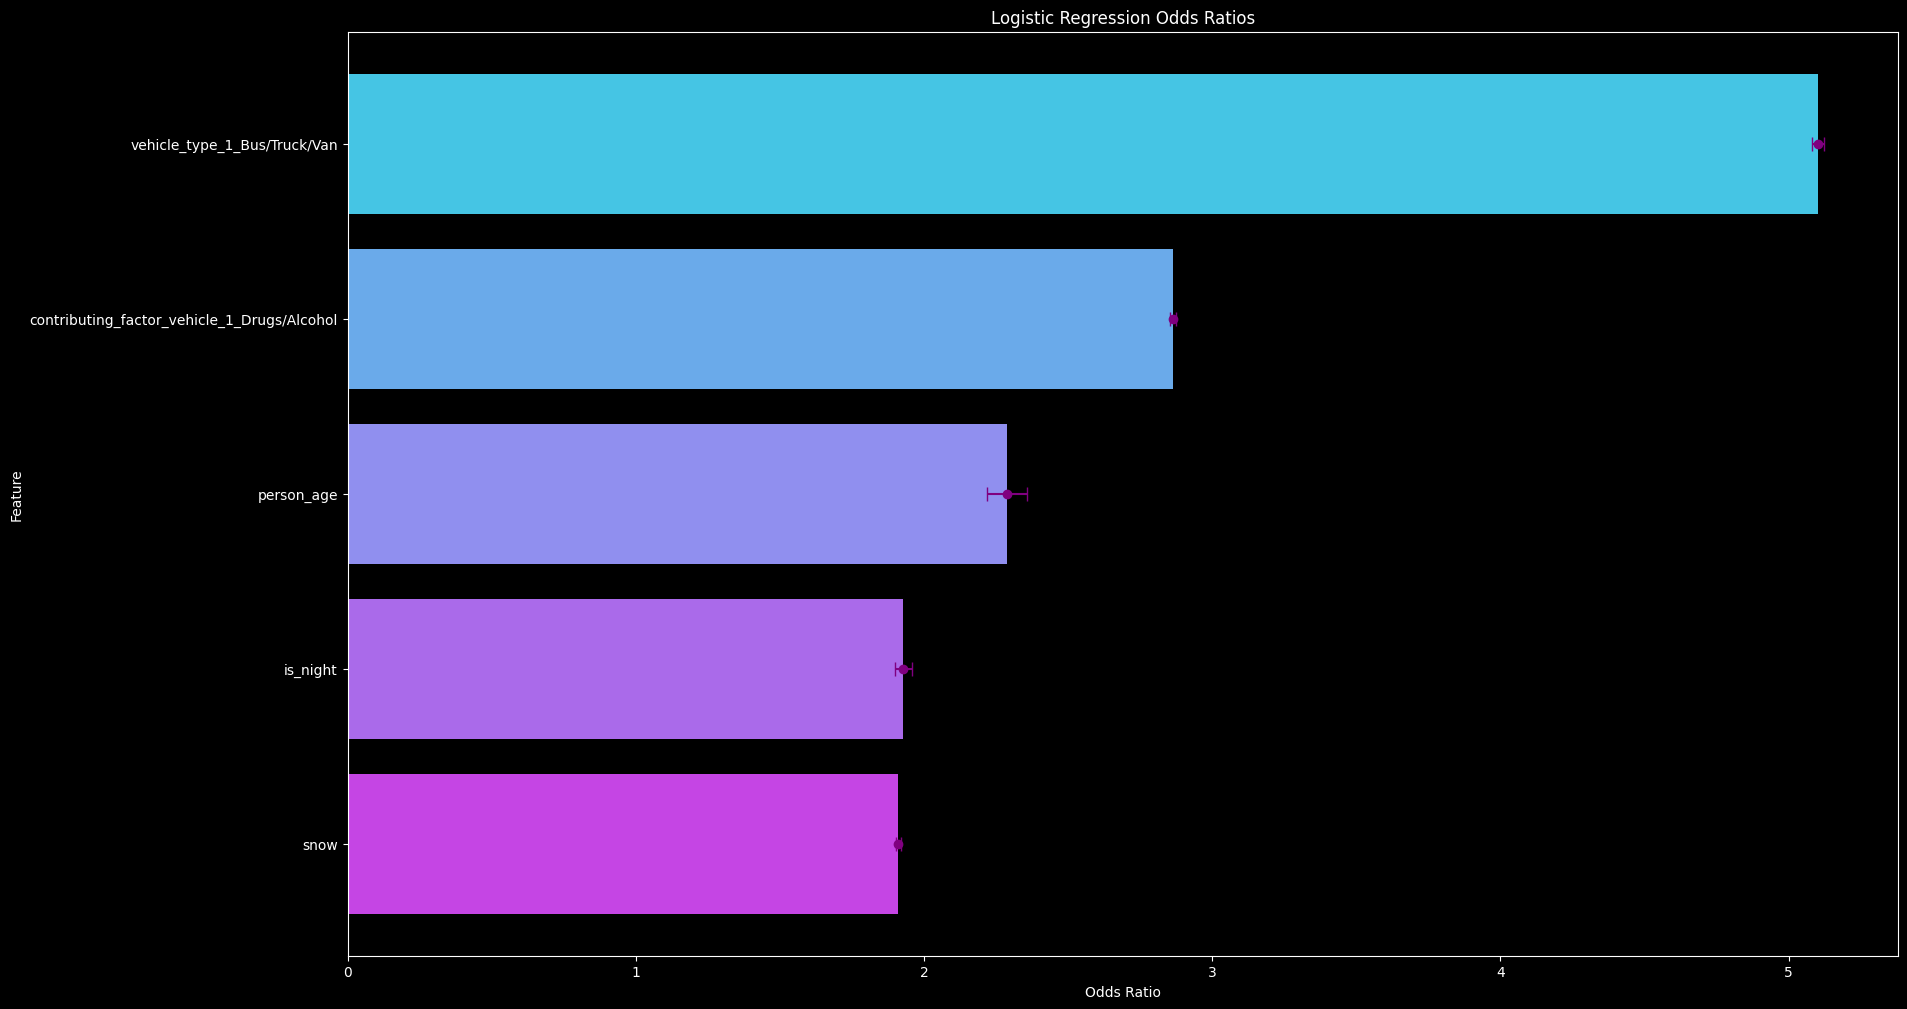

In [39]:
top5 = df_odds_ratios.head(5)

plt.figure(figsize=(20, 12))
sns.barplot(x='Odds Ratio', y='Feature', data=top5, palette='cool')
plt.errorbar(x=top5['Odds Ratio'], y=range(len(top5)), xerr=top5['Confidence Interval'], fmt='o', capsize=5, color='purple')
plt.xlabel('Odds Ratio')
plt.title('Logistic Regression Odds Ratios')
plt.show()

In [20]:
df_odds_ratios['Percentage Change (Rounded)'] = round((df_odds_ratios['Odds Ratio'] - 1) * 100, 2)

df_odds_ratios.head(50)

Feature  \
vehicle_type_1_Bus/Truck/Van                                             vehicle_type_1_Bus/Truck/Van   
contributing_factor_vehicle_1_Drugs/Alcohol               contributing_factor_vehicle_1_Drugs/Alcohol   
person_age                                                                                 person_age   
is_night                                                                                     is_night   
snow                                                                                             snow   
person_type                                                                               person_type   
near_calming                                                                             near_calming   
person_sex                                                                                 person_sex   
is_weekend                                                                                 is_weekend   
near_cam                                                                                     near_cam   
contributing_factor_vehicle_1_Pedestrian/Bicycl...  contributing_factor_vehicle_1_Pedestrian/Bicyc...   
avg_temp                                                                                     avg_temp   
commute_walk_percent                                                             commute_walk_percent   
contributing_factor_vehicle_1_Vehicle Defective       contributing_factor_vehicle_1_Vehicle Defective   
vehicle_type_1_SUV/Pickup                                                   vehicle_type_1_SUV/Pickup   
contributing_factor_vehicle_1_Environmental               contributing_factor_vehicle_1_Environmental   
complaints_within100m                                                           complaints_within100m   
street_width                                                                             street_width   
cam_distance                                                                             cam_distance   
vehicle_type_1_Motorcycle/Moped/Scooter                       vehicle_type_1_Motorcycle/Moped/Scooter   
below_poverty_count_percent                                               below_poverty_count_percent   
rain_2.5mm                                                                                 rain_2.5mm   
median_income                                                                           median_income   
commute_other_percent                                                           commute_other_percent   
commute_car_percent                                                               commute_car_percent   
vehicle_type_1_E-Bike                                                           vehicle_type_1_E-Bike   
commute_public_transport_percent                                     commute_public_transport_percent   
contributing_factor_vehicle_1_Speeding/Traffic ...  contributing_factor_vehicle_1_Speeding/Traffic...   
contributing_factor_vehicle_1_Driver Inattentio...  contributing_factor_vehicle_1_Driver Inattenti...   
within_vz_priority                                                                 within_vz_priority   
vehicle_type_1_Sedan                                                             vehicle_type_1_Sedan   
vehicle_type_1_Bicycle                                                         vehicle_type_1_Bicycle   
vehicle_type_1_Taxi                                                               vehicle_type_1_Taxi   
contributing_factor_vehicle_1_Unsafe Driving             contributing_factor_vehicle_1_Unsafe Driving   

                                                    Odds Ratio  \
vehicle_type_1_Bus/Truck/Van                          5.102331   
contributing_factor_vehicle_1_Drugs/Alcohol           2.863908   
person_age                                            2.288387   
is_night                                              1.928128   
snow                                                  1.911020   
person_type           

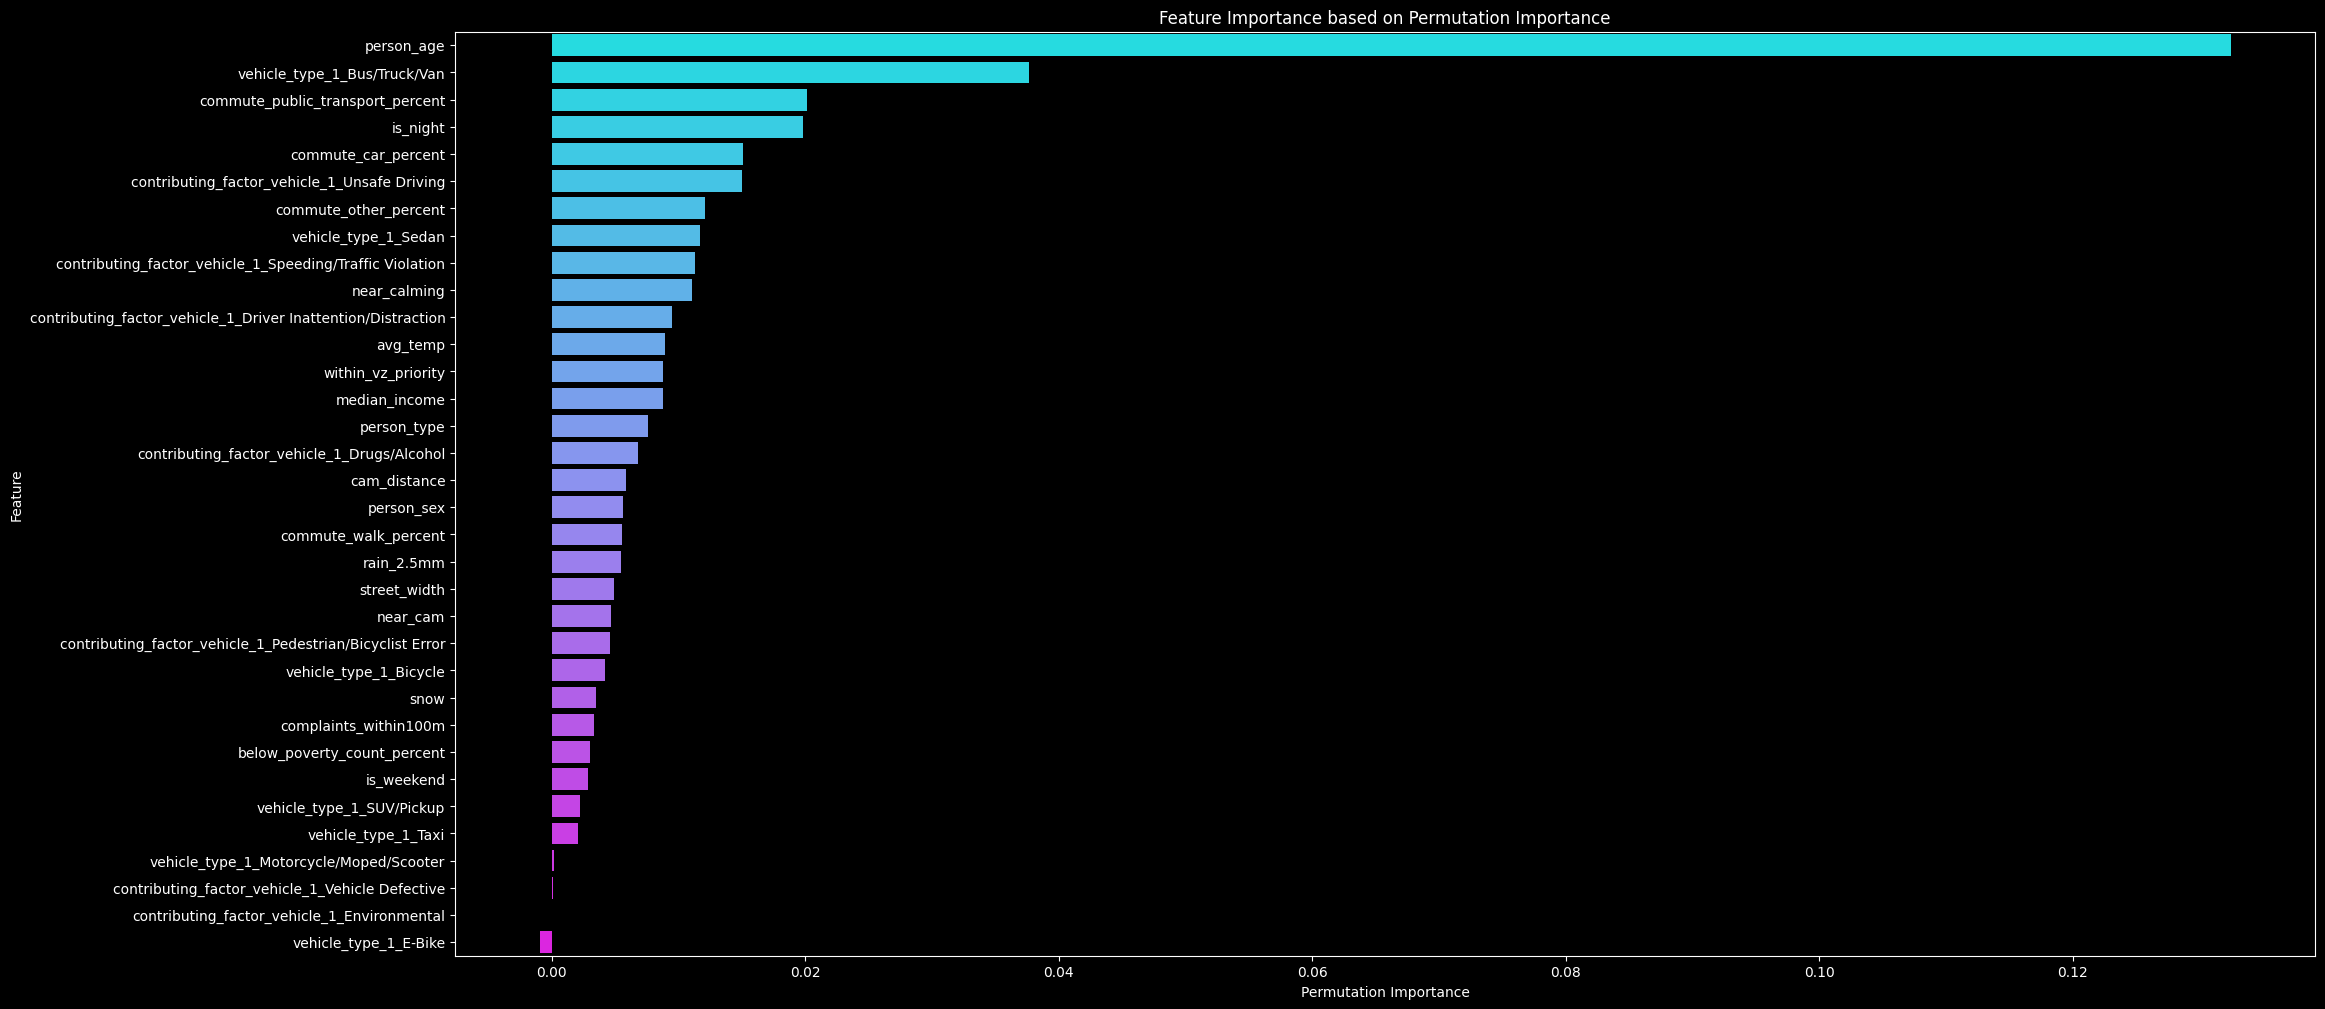

In [13]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(lr, X_resampled_lr, y_resampled_lr, n_repeats=30, random_state=random_state)

feature_importance = perm_importance.importances_mean
feature_names = X_train.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(24, 12))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='cool')
plt.xlabel('Permutation Importance')
plt.title('Feature Importance based on Permutation Importance')
plt.show()